In [480]:
import pandas as pd
import math
import datetime
import os
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import numpy as np
from itertools import chain
import math
from geopy.distance import distance

# dbscan clustering
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from geopy.distance import great_circle
import time

%matplotlib inline

# Project WP1-2
### code 10: identify region waypoints based on DBSCAN, hourly based data.
<span style='font-family:"Times New Roman"'> <span styel=''> 
    
Dataset "ais_hourly_withDistStartEndTerms_3000plus.csv" and "ports_update1.csv". 

This code is to train the waypoints in regions by DBSCAN algorithm: Gulf/Caribbean, and NE Asia. The results will be used as a demo for the further points identifications. 
    
### Basic steps: 
    a) Load and visualize selected region data;
    b) DBSCAN training;
    c) clusters and waypoints visualization;

# a) Load and visualize selected region data

In [458]:
df_3000plus=pd.read_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/cleanedData/ais_hourly_withDistStartEndTerms_3000plus.csv")
df_routes=pd.read_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/cleanedData/aisRoutes_westAme2EastAsia.csv")
df_ports = pd.read_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/cleanedData/ports_update1.csv")

In [581]:

def draw_map(m, scale=0.5):
    """
    plot backgroud map
    m: Basemap object
    scale: plot scale
    return: plot a backgroud map
    """
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    #m.bluemarble(scale=scale)  #Project NASA's blue marble image onto the map
    #m.drawcoastlines()
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def plotPorts(df,dispBounds=(-30,60,255,330),directory="C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/Nov/",
              file_name="aisPoints_Gulf.png"):
    """
    Plot ports on geomap
    df: dataframe with location coordinates
    dispBounds=tuple (lat_down,lat_up,lon_left,lon_right)
    """
    #bbox=(df.ais_position_latitude.min(),df.ais_position_latitude.max(),df.ais_position_longitude.min(),df.ais_position_longitude.max())                                                        
    bbox=dispBounds
    #print ("The respective minimum and maximum latitude and longitude coordiates of ports are:",bbox)

    fig,ax=plt.subplots(figsize=(16,10))
    m = Basemap(ax=ax,projection='cyl',resolution='l',
                llcrnrlat=bbox[0], urcrnrlat=bbox[1],
                llcrnrlon=bbox[2], urcrnrlon=bbox[3])

    # df.ais_position_longitude    
    ax.scatter(df.ais_lon_new,df.Latitude,s=40) 
    draw_map(m)
    m.drawmeridians(np.arange(0,360,5),labels=[True,False,False,True],linewidth=0.5,fontsize=12)
    m.drawparallels(np.arange(-45,61,5),labels=[1,0,1,1], linewidth=0.5, fontsize=12)

    ax.set_xlim(bbox[2],bbox[3]);
    ax.set_ylim(bbox[0],bbox[1]);
    ax.set_xlabel("Longitude",fontsize=18)
    ax.set_ylabel("Latitude",fontsize=18)
    ax.xaxis.set_label_coords(0.55, -0.06)
    ax.yaxis.set_label_coords(-0.06,0.45)
    #ax.legend(loc='best',fontsize=10,frameon=False)
    fig.savefig(directory+file_name,dpi=400)
    
def trans_coods(df):
    """
    transform the coordinates of longituds from format (-180,180) to format (0,360)
    return: a new dataframe with an extra column "ais_lon_new"
    """
    df_copy=df.copy()
    for ix,row in df_copy.iterrows():

        lon=row["Longitude"]

        if lon<=0:
            df_copy.at[ix,"ais_lon_new"]=lon+360
        else:
            df_copy.at[ix,"ais_lon_new"]=lon
    return df_copy

def get_centroid(cluster):
  """calculate the centroid of a cluster of geographic coordinate points
  Args:
    cluster coordinates, nx2 array-like (array, list of lists, etc) 
    n is the number of points(latitude, longitude)in the cluster.
  Return:
    geometry centroid of the cluster
    
  """
  cluster_ary = np.asarray(cluster)
  centroid = cluster_ary.mean(axis = 0)
  return centroid


# ais data in Gulf region

----------------------------------------------------------------------------------------------------------------------
Plot all ais points with 3000 plus journey distance:
----------------------------------------------------------------------------------------------------------------------
 the selected reigon in Gulf bays and Caribbean region:


<ipython-input-686-15ab2515ecfb>:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_remove=df_gulf[mask_lat1 & mask_lon1]


LR_IMO_Ship_No         MMSI  Latitude  Longitude ais_position_timestamp  \
102       9240897.0  565580000.0  9.442650 -79.929317      20200302 23:49:44   
135       9240897.0  565580000.0  9.219367 -79.930933      20200303 14:47:38   
147       9240897.0  565580000.0  9.442517 -79.929317      20200302 22:55:44   
160       9240897.0  565580000.0  9.222800 -79.933083      20200303 15:51:03   
168       9240897.0  565580000.0  8.239117 -79.442167      20200304 03:58:18   

                 MoveStatus  Speed Heading Destination  \
102                Anchored    0.1      30    QUINTERO   
135                Anchored    0.0       4    QUINTERO   
147                Anchored    0.0      33    QUINTERO   
160  Under way using engine    1.6     106    QUINTERO   
168  Under way using engine   14.5     181    QUINTERO   

              DestinationTidied  ...  start_lon  start_calls  \
102  Quintero LNG Terminal Dock  ...  -79.88468        187.0   
135  Quintero LNG Terminal Dock  ...  -79.88468        187.0   
147  Quintero LNG Terminal Dock  ...  -79.88468        187.0   
160  Quintero LNG Terminal Dock  ...  -79.88468        187.0   
168  Quintero LNG Terminal Dock  ...  -79.88468        187.0   

               start_group  end_region     end_terminal   end_lat   end_lon  \
102  Rodman Piers Terminal  West Latin  Puerto Ventanas -32.75828 -71.50558   
135  Rodman Piers Terminal  West Latin  Puerto Ventanas -32.75828 -71.50558   
147  Rodman Piers Terminal  West Latin  Puerto Ventanas -32.75828 -71.50558   
160  Rodman Piers Terminal  West Latin  Puerto Ventanas -32.75828 -71.50558   
168  Rodman Piers Terminal  West Latin  Puerto Ventanas -32.75828 -71.50558   

    end_calls end_group  ais_lon_new  
102      49.0  Quintero   280.070683  
135      49.0  Quintero   280.069067  
147      49.0  Quintero   280.070683  
160      49.0  Quintero   280.066917  
168      49.0  Quintero   280.557833  

[5 rows x 30 columns]

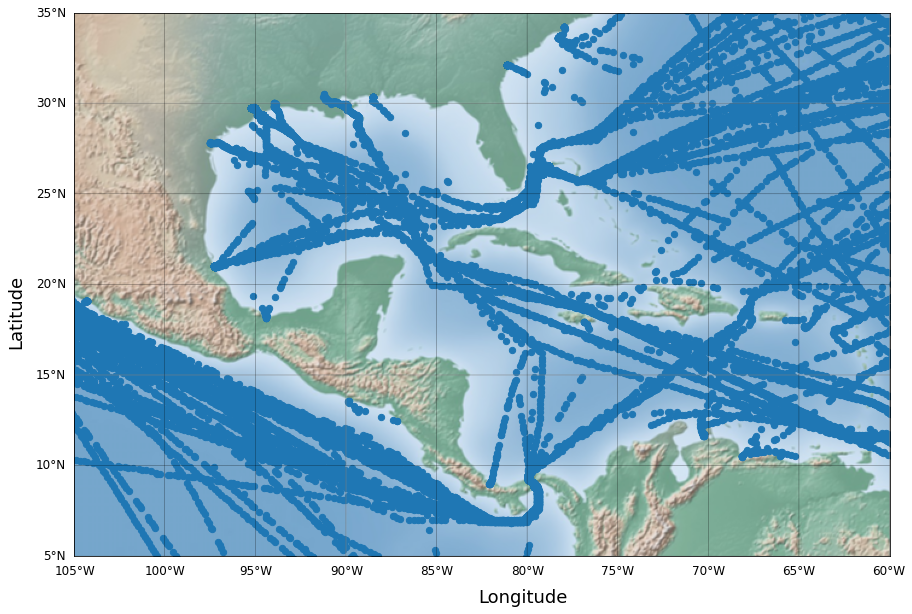

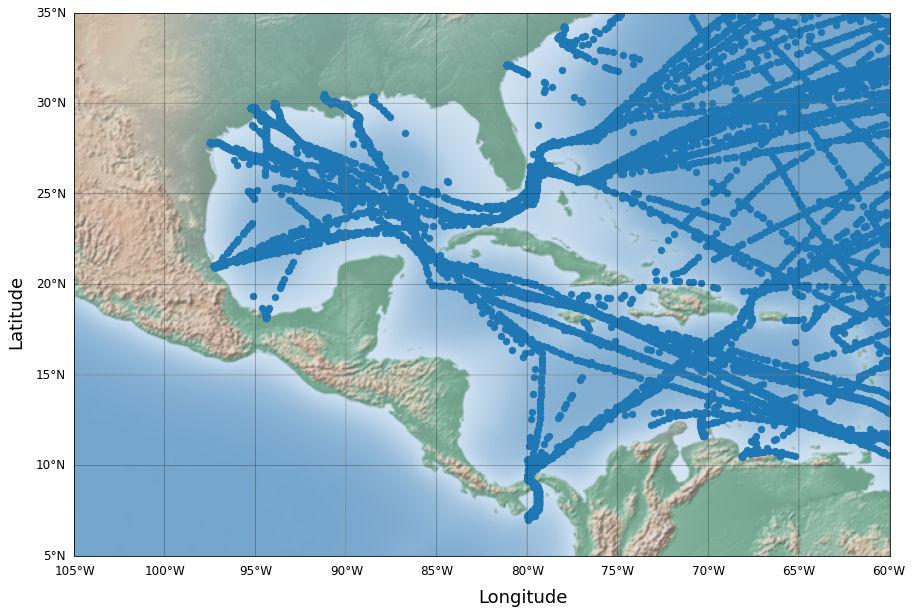

In [686]:
# obtain all the ais points in Gulf and Caribbean region

# all points with 3000 plus
print("----------------------------------------------------------------------------------------------------------------------")
print ("Plot all ais points with 3000 plus journey distance:")
df_3000plus=trans_coods(df_3000plus)
plotPorts(df_3000plus,(5,35,255,300))

print("----------------------------------------------------------------------------------------------------------------------")
# select regions in Gulf bays and Caribbean region. 
#locations=[lat_d,lat_u,long_l,long_r], [5,30,-98,-75]
lon_l=360-98
lon_r=360-60
mask_lat=(df_3000plus.Latitude>6) & (df_3000plus.Latitude<35)
mask_lon=(df_3000plus.ais_lon_new>lon_l)&(df_3000plus.ais_lon_new<lon_r)

# remove points in [0,15,-98,-85]
mask_lat1=(df_3000plus.Latitude>5) & (df_3000plus.Latitude<16)
mask_lon1=(df_3000plus.ais_lon_new>360-98)&(df_3000plus.ais_lon_new<360-80)

df_gulf=df_3000plus[mask_lat&mask_lon]
ix_gulf=df_gulf.index

df_remove=df_gulf[mask_lat1 & mask_lon1]
ix_remove=df_remove.index

ix_gulf_update=[ix for ix in ix_gulf if ix not in ix_remove]

df_gulf_update=df_gulf.loc[ix_gulf_update]

print(" the selected reigon in Gulf bays and Caribbean region:")
plotPorts(df_gulf_update,(5,35,255,300))

df_gulf_update.head()

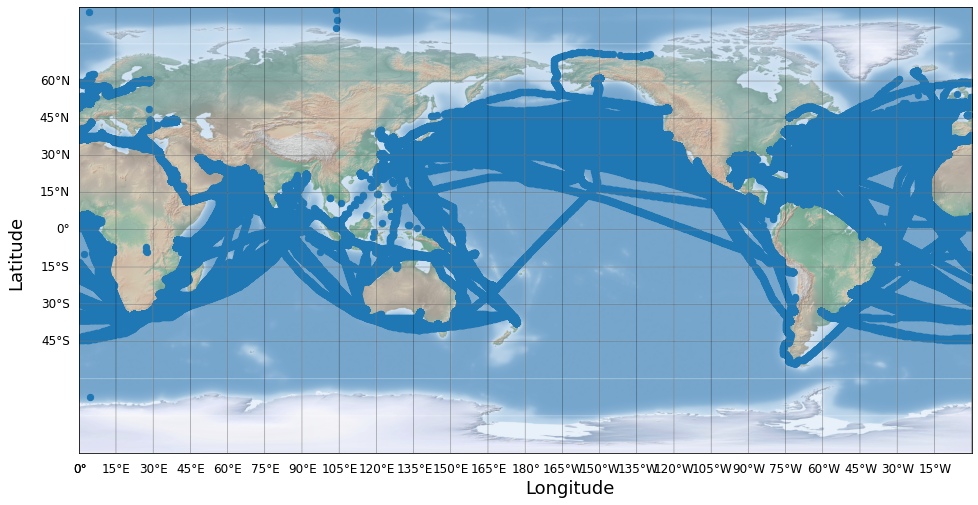

In [580]:
plotPorts(df_3000plus,(-90,90,0,360))

# ais point in NE Asia and East Asia

----------------------------------------------------------------------------------------------------------------------
Plot all ais points with 3000 plus journey distance:
----------------------------------------------------------------------------------------------------------------------
 the selected reigon in North Asia and North East Asia region:


LR_IMO_Ship_No         MMSI   Latitude   Longitude  \
374       9246798.0  372200000.0  30.144832  122.389005   
383       9246798.0  372200000.0  30.116355  122.177905   
385       9246798.0  372200000.0  30.116372  122.177902   
389       9246798.0  372200000.0  30.146242  122.389835   
390       9246798.0  372200000.0  30.153322  122.387292   

    ais_position_timestamp MoveStatus  Speed Heading Destination  \
374      20200802 22:49:48   Anchored    0.2      96    ZHOUSHAN   
383      20200802 04:49:01     Moored    0.0     178    ZHOUSHAN   
385      20200802 08:31:03     Moored    0.0     178    ZHOUSHAN   
389      20200802 12:49:48   Anchored    0.6     133    ZHOUSHAN   
390      20200802 11:55:07     Moored    2.2     139    ZHOUSHAN   

    DestinationTidied  ...  start_lon  start_calls start_group end_region  \
374          Zhoushan  ... -110.30964        382.0      La Paz  East Asia   
383          Zhoushan  ... -110.30964        382.0      La Paz  East Asia   
385          Zhoushan  ... -110.30964        382.0      La Paz  East Asia   
389          Zhoushan  ... -110.30964        382.0      La Paz  East Asia   
390          Zhoushan  ... -110.30964        382.0      La Paz  East Asia   

                         end_terminal   end_lat    end_lon end_calls  \
374  Jinhai Intelligent Manufacturing  30.26675  122.25564      14.0   
383  Jinhai Intelligent Manufacturing  30.26675  122.25564      14.0   
385  Jinhai Intelligent Manufacturing  30.26675  122.25564      14.0   
389  Jinhai Intelligent Manufacturing  30.26675  122.25564      14.0   
390  Jinhai Intelligent Manufacturing  30.26675  122.25564      14.0   

    end_group  ais_lon_new  
374    Ningbo   122.389005  
383    Ningbo   122.177905  
385    Ningbo   122.177902  
389    Ningbo   122.389835  
390    Ningbo   122.387292  

[5 rows x 30 columns]

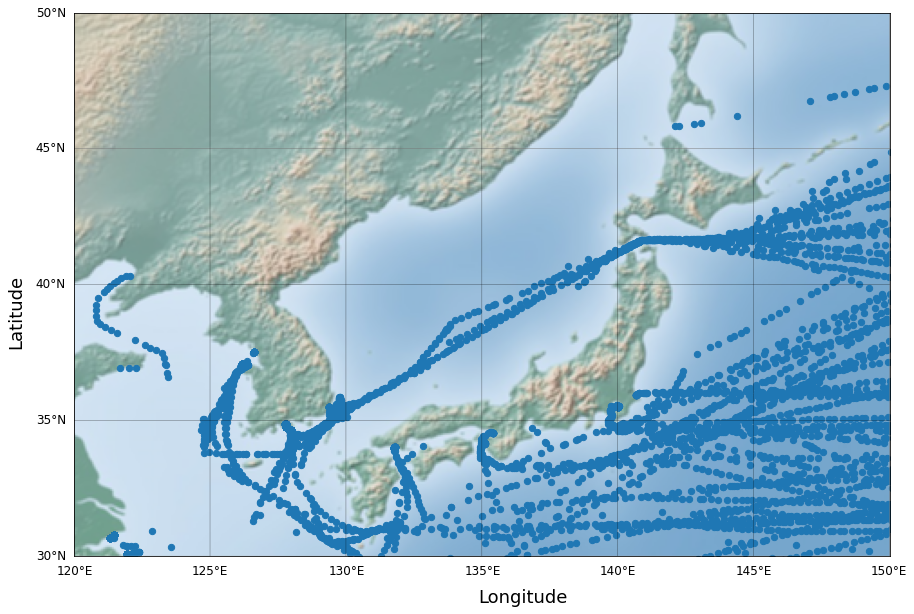

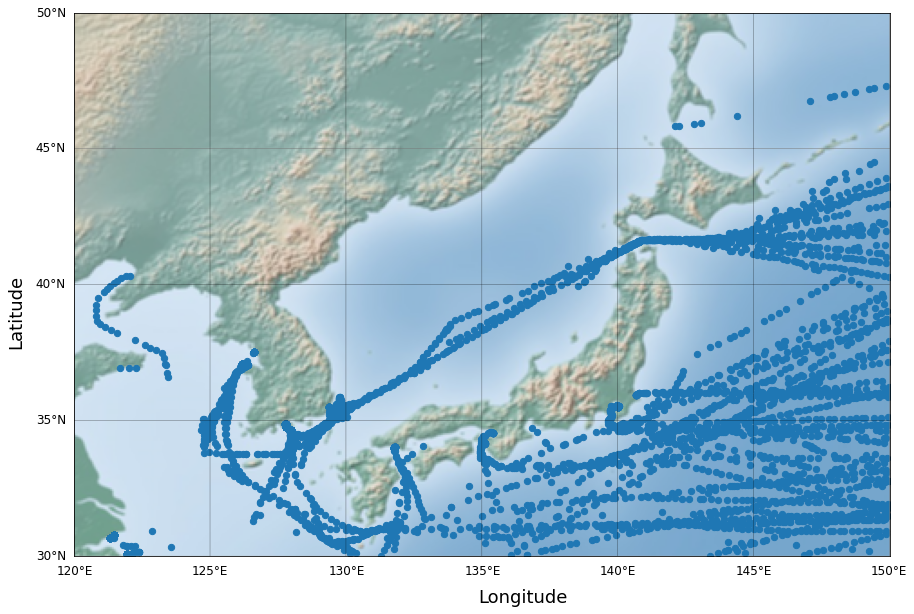

In [687]:
# obtain all the ais points in East and North East Asia region

# all points with 3000 plus
print("----------------------------------------------------------------------------------------------------------------------")
print ("Plot all ais points with 3000 plus journey distance:")
df_3000plus=trans_coods(df_3000plus)
plotPorts(df_3000plus,(30,50,120,150),file_name="points_NEasia")

print("----------------------------------------------------------------------------------------------------------------------")
#locations=[lat_d,lat_u,long_l,long_r], [30,50,120,150]

mask_lat=(df_3000plus.Latitude>30) & (df_3000plus.Latitude<50)
mask_lon=(df_3000plus.ais_lon_new>120)&(df_3000plus.ais_lon_new<150)

# # remove points in [0,15,-98,-85]
# mask_lat1=(df_3000plus.Latitude>5) & (df_3000plus.Latitude<16)
# mask_lon1=(df_3000plus.ais_lon_new>360-98)&(df_3000plus.ais_lon_new<360-80)

df_Easia=df_3000plus[mask_lat&mask_lon]
ix_Easia=df_Easia.index

# df_remove=df_gulf[mask_lat1 & mask_lon1]
# ix_remove=df_remove.index

# ix_gulf_update=[ix for ix in ix_gulf if ix not in ix_remove]

# df_gulf_update=df_gulf.loc[ix_gulf_update]

print(" the selected reigon in North Asia and North East Asia region:")
plotPorts(df_Easia,(30,50,120,150),file_name="points_NEasia_1")

df_Easia.head()

# 2) DBSCAN training

In [619]:
# functions for dbscan training. 

def dbscan_train(df,eps=18.5,minPts=12):
    """
    train all given points in the form of ndarray np.array([[X1,X2]])
    df: dataframe with training points, containing (Latitude, ais_lon_new) for points in Pacific ocean
        (Latitude,Longitude) for points in Atlantic Ocean.
    eps: the maximum distance to be in a cluster, here can be considered as the unit of km. 
    minPts: the minimum number of points in a cluster
    
    return: the fitted model, the cluster labels, the number of clusters (including noise label -1), model score
    """
    
    X = df[["Latitude","ais_lon_new"]]
    X = StandardScaler().fit_transform(X)

    kms_per_rad = 6371.0088
    epsilon = eps/kms_per_rad
    start_time = time.time()

    # change to radias for a possible better fitting. maybe a normalization should be introduced.
    dbsc = (DBSCAN(eps=epsilon, min_samples=minPts, algorithm='ball_tree', metric='haversine')
            .fit(np.radians(X)))
    
    # get cluster labels, and the number of clusters
    labels = dbsc.labels_
    num_clusters = len(set(dbsc.labels_))
    
    # accuracy
    score=metrics.silhouette_score(X, labels)

    # print the outcome
    message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
    print ("current minPts : {}".format(minPts))
    print(message.format(len(X), num_clusters, 100*(1 - float(num_clusters) / len(X)), time.time()-start_time))
    print('Silhouette coefficient: {:0.03f}'.format(score))

    return dbsc, labels, num_clusters, score
 
    
def clusters_2Series_2df(df,labels,num_clusters):
    """
    df: the dataframe including  training data X
    labels: ndarray labels for each point in the training dataset
    num_clusters: the number of labels
    
    return: a dataframe containing only clusters centers (average), excluding noise point
    """
    X = df[["Latitude","ais_lon_new"]]

    # turn the clusters into a pandas series,where each element is a cluster of points
    dbsc_clusters = pd.Series([X[labels==n] for n in range(num_clusters)])

    # get centroid of each cluster
    fac_centroids = dbsc_clusters.map(get_centroid)

    # unzip the list of centroid points (lat, lon) tuples into separate lat and lon lists
    cent_lats, cent_lons = zip(*fac_centroids)

    # from these lats/lons create a new df of one representative point for eac cluster
    df_clusters = pd.DataFrame({'ais_lon_new':cent_lons, 'Latitude':cent_lats})
    df_clusters=df_clusters.dropna()
    
    return df_clusters

# display all the clusters with their own points
# Black removed and is used for noise instead.

def plot_clusters_points(df,dbsc,dispBounds=(5,35,255,300),directory="C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/Nov/",
              file_name="waypoints_Clusters_Gulf.png"):
    """
    plot all the trained clusters (including all points in a cluster) on a map
    
    df: dataframe withh all ais points in the cluster regions.
    dbsc: the trained dbscan model
    dispBounds:tuple (lat_down,lat_up,lon_left,lon_right)
    
    """
    X=df[["Latitude","ais_lon_new"]]
    
    # df.labels_: Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.
    core_samples_mask = np.zeros_like(dbsc.labels_, dtype=bool)

    # db.core_sample_indices_: Indices of core samples. 
    core_samples_mask[dbsc.core_sample_indices_] = True

    # Number of clusters in labels, ignoring noise if present.
    # label: Noisy samples are given the label -1.
    cord_cluster_labels = dbsc.labels_
    n_clusters_ = len(set(cord_cluster_labels)) - (1 if -1 in cord_cluster_labels else 0)
    n_noise_ = list(cord_cluster_labels).count(-1)

    unique_labels = set(cord_cluster_labels)
#     print ("the unique lables:",unique_labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]

    bbox=dispBounds
    #print ("The respective minimum and maximum latitude and longitude coordiates of ports are:",bbox)
    fig,ax=plt.subplots(figsize=(16,10))
    m = Basemap(ax=ax,projection='cyl',resolution='l',
                llcrnrlat=bbox[0], urcrnrlat=bbox[1],
                llcrnrlon=bbox[2], urcrnrlon=bbox[3])

    # df.ais_position_longitude    
    draw_map(m)
    m.drawmeridians(np.arange(0,360,5),labels=[True,False,False,True],linewidth=0.5,fontsize=12)
    m.drawparallels(np.arange(-45,61,5),labels=[1,0,1,1], linewidth=0.5, fontsize=12)
    ax.set_xlim(bbox[2],bbox[3]);
    ax.set_ylim(bbox[0],bbox[1]);
    ax.set_xlabel("Longitude",fontsize=18)
    ax.set_ylabel("Latitude",fontsize=18)
    ax.xaxis.set_label_coords(0.55, -0.06)
    ax.yaxis.set_label_coords(-0.06,0.45)

    X=X.values
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
    #         continue

        # matrix of mask for all labels: label==k--> True; Otherwise-->False
        class_member_mask = (cord_cluster_labels == k)

        # plot the core sample samples
        xy = X[class_member_mask & core_samples_mask]
        ax.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=16)

        # plot the non core samples and noise samples
        xy = X[class_member_mask & ~core_samples_mask]
        ax.plot(xy[:, 1], xy[:, 0], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=2)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    fig.savefig(directory+file_name,dpi=400)

def plot_clusters_center(df_clusters,dispBounds=(5,35,255,300),directory="C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/Nov/",
              file_name="waypoints_Gulf.png"):
    """
    plot the centers of cluster on a given map
    df_clusters: dataframe including only the clusters mean value (lon,lat)
    dispBounds:tuple (lat_down,lat_up,lon_left,lon_right)
    """
    bbox=dispBounds
    #print ("The respective minimum and maximum latitude and longitude coordiates of ports are:",bbox)
    fig,ax=plt.subplots(figsize=(16,10))
    m = Basemap(ax=ax,projection='cyl',resolution='l',
                llcrnrlat=bbox[0], urcrnrlat=bbox[1],
                llcrnrlon=bbox[2], urcrnrlon=bbox[3])
    # df.ais_position_longitude    
    draw_map(m)
    m.drawmeridians(np.arange(0,360,5),labels=[True,False,False,True],linewidth=0.5,fontsize=12)
    m.drawparallels(np.arange(-45,61,5),labels=[1,0,1,1], linewidth=0.5, fontsize=12)
    ax.set_xlim(bbox[2],bbox[3]);
    ax.set_ylim(bbox[0],bbox[1]);
    ax.set_xlabel("Longitude",fontsize=18)
    ax.set_ylabel("Latitude",fontsize=18)
    ax.xaxis.set_label_coords(0.55, -0.06)
    ax.yaxis.set_label_coords(-0.06,0.45)

    ax.plot(df_clusters["ais_lon_new"],df_clusters["Latitude"],'o',markeredgecolor='r',markersize=16)
    fig.savefig(directory+file_name,dpi=400)

In [585]:
#for gulf region
dbsc, labels, num_clusters, score=dbscan_train(df_gulf_update,eps=14,minPts=111) 
df_clusters=clusters_2Series_2df(df_gulf_update,labels,num_clusters)


Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.06 seconds
Silhouette coefficient: 0.334


<ipython-input-581-be4b73edf7db>:83: RuntimeWarning: Mean of empty slice.
  centroid = cluster_ary.mean(axis = 0)
C:\Users\jiec\Anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


In [673]:
# for aisan region
# eps=5, minPts=25, score=0.089
#eps=6, minPts=25, score=0.118
dbsc1, labels1, num_clusters1, score1=dbscan_train(df_Easia,eps=8,minPts=20) 
df_clusters1=clusters_2Series_2df(df_Easia,labels1,num_clusters1)

current minPts : 20
Clustered 5,054 points down to 20 clusters, for 99.6% compression in 0.67 seconds
Silhouette coefficient: 0.252


<ipython-input-581-be4b73edf7db>:83: RuntimeWarning: Mean of empty slice.
  centroid = cluster_ary.mean(axis = 0)
C:\Users\jiec\Anaconda3\lib\site-packages\numpy\core\_methods.py:153: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


#  Hyperparameters tunning 

In [536]:
minPts=np.arange(1,250)
scores=[]
score_max=0
eps=np.arange(2,16)

scores_all=dict()

for ep in eps:
    print ("the current eps distance is:",ep)
    for pt in minPts:
        _, _, _, score=dbscan_train(df_gulf_update,eps=ep,minPts=pt) 
        if score>score_max:
            score_max=score
        scores_all.setdefault(ep,[]).append(score)

print (score_max)

the current eps distance is: 2
Clustered 12,612 points down to 1,777 clusters, for 85.9% compression in 2.81 seconds
Silhouette coefficient: 0.067
Clustered 12,612 points down to 727 clusters, for 94.2% compression in 2.77 seconds
Silhouette coefficient: 0.066
Clustered 12,612 points down to 371 clusters, for 97.1% compression in 2.73 seconds
Silhouette coefficient: 0.125
Clustered 12,612 points down to 235 clusters, for 98.1% compression in 2.75 seconds
Silhouette coefficient: 0.132
Clustered 12,612 points down to 171 clusters, for 98.6% compression in 2.75 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 132 clusters, for 99.0% compression in 2.73 seconds
Silhouette coefficient: 0.046
Clustered 12,612 points down to 113 clusters, for 99.1% compression in 2.78 seconds
Silhouette coefficient: -0.025
Clustered 12,612 points down to 80 clusters, for 99.4% compression in 2.75 seconds
Silhouette coefficient: -0.013
Clustered 12,612 points down to 58 clusters, for 99.5%

Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.80 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.79 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.83 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.91 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.82 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.87 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.80 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.86 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.86 seconds
Silhouette co

Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.87 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.01 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.96 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.89 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.88 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.87 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.84 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.86 seconds
Silhouette coefficient: 0.082
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.78 seconds
Silhouette co

Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.93 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.88 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.98 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.88 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.85 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.82 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.91 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.84 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.81 seconds
Silhouette co

Clustered 12,612 points down to 15 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.119
Clustered 12,612 points down to 16 clusters, for 99.9% compression in 2.85 seconds
Silhouette coefficient: 0.098
Clustered 12,612 points down to 16 clusters, for 99.9% compression in 2.83 seconds
Silhouette coefficient: 0.097
Clustered 12,612 points down to 14 clusters, for 99.9% compression in 2.86 seconds
Silhouette coefficient: 0.075
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.92 seconds
Silhouette coefficient: 0.071
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.02 seconds
Silhouette coefficient: 0.084
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.91 seconds
Silhouette coefficient: 0.079
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.90 seconds
Silhouette coefficient: 0.078
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.94 seconds
Silhouette co

Clustered 12,612 points down to 9 clusters, for 99.9% compression in 2.95 seconds
Silhouette coefficient: 0.164
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.164
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.164
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.01 seconds
Silhouette coefficient: 0.146
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 2.86 seconds
Silhouette coefficient: 0.146
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 2.85 seconds
Silhouette coefficient: 0.146
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 2.88 seconds
Silhouette coefficient: 0.146
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.78 seconds
Silhouette coefficient: 0.145
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.90 seconds
Silhouette coefficient

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.04 seconds
Silhouette coefficient: 0.140
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.99 seconds
Silhouette coefficient: 0.140
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.05 seconds
Silhouette coefficient: 0.140
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.98 seconds
Silhouette coefficient: 0.140
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.98 seconds
Silhouette coefficient: 0.140
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.02 seconds
Silhouette coefficient: 0.140
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.95 seconds
Silhouette coefficient: 0.140
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.23 seconds
Silhouette coefficient: 0.140
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.22 seconds
Silhouette coefficient

Clustered 12,612 points down to 43 clusters, for 99.7% compression in 3.36 seconds
Silhouette coefficient: 0.088
Clustered 12,612 points down to 43 clusters, for 99.7% compression in 3.15 seconds
Silhouette coefficient: 0.067
Clustered 12,612 points down to 43 clusters, for 99.7% compression in 3.02 seconds
Silhouette coefficient: 0.027
Clustered 12,612 points down to 38 clusters, for 99.7% compression in 3.13 seconds
Silhouette coefficient: 0.066
Clustered 12,612 points down to 36 clusters, for 99.7% compression in 3.10 seconds
Silhouette coefficient: 0.056
Clustered 12,612 points down to 35 clusters, for 99.7% compression in 3.12 seconds
Silhouette coefficient: 0.057
Clustered 12,612 points down to 35 clusters, for 99.7% compression in 3.36 seconds
Silhouette coefficient: 0.117
Clustered 12,612 points down to 34 clusters, for 99.7% compression in 3.19 seconds
Silhouette coefficient: 0.116
Clustered 12,612 points down to 31 clusters, for 99.8% compression in 3.30 seconds
Silhouette co

Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.98 seconds
Silhouette coefficient: 0.095
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.095
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.91 seconds
Silhouette coefficient: 0.094
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.87 seconds
Silhouette coefficient: 0.094
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.094
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.91 seconds
Silhouette coefficient: 0.094
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.88 seconds
Silhouette coefficient: 0.094
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.86 seconds
Silhouette coefficient: 0.094
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.89 seconds
Silhouette co

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.86 seconds
Silhouette coefficient: 0.161
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.82 seconds
Silhouette coefficient: 0.161
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.84 seconds
Silhouette coefficient: 0.161
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.79 seconds
Silhouette coefficient: 0.161
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.88 seconds
Silhouette coefficient: 0.160
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.82 seconds
Silhouette coefficient: 0.160
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.85 seconds
Silhouette coefficient: 0.160
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.86 seconds
Silhouette coefficient: 0.160
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.83 seconds
Silhouette coefficient

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.03 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.00 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.96 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.97 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.15 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.47 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.85 seconds
Silhouette coefficient

Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.93 seconds
Silhouette coefficient: 0.158
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.91 seconds
Silhouette coefficient: 0.158
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.92 seconds
Silhouette coefficient: 0.155
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.99 seconds
Silhouette coefficient: 0.154
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.90 seconds
Silhouette coefficient: 0.154
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.88 seconds
Silhouette coefficient: 0.154
Clustered 12,612 points down to 14 clusters, for 99.9% compression in 2.84 seconds
Silhouette coefficient: 0.143
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 2.83 seconds
Silhouette co

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.99 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.98 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.02 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.89 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.89 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.88 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.94 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.02 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.91 seconds
Silhouette coefficient

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.97 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.96 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.00 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.03 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.92 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.90 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.87 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.45 seconds
Silhouette coefficient

Clustered 12,612 points down to 26 clusters, for 99.8% compression in 2.98 seconds
Silhouette coefficient: 0.114
Clustered 12,612 points down to 27 clusters, for 99.8% compression in 2.88 seconds
Silhouette coefficient: 0.095
Clustered 12,612 points down to 26 clusters, for 99.8% compression in 3.23 seconds
Silhouette coefficient: 0.148
Clustered 12,612 points down to 22 clusters, for 99.8% compression in 3.41 seconds
Silhouette coefficient: 0.210
Clustered 12,612 points down to 23 clusters, for 99.8% compression in 3.29 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 23 clusters, for 99.8% compression in 3.08 seconds
Silhouette coefficient: 0.195
Clustered 12,612 points down to 28 clusters, for 99.8% compression in 2.90 seconds
Silhouette coefficient: 0.168
Clustered 12,612 points down to 25 clusters, for 99.8% compression in 2.84 seconds
Silhouette coefficient: 0.159
Clustered 12,612 points down to 26 clusters, for 99.8% compression in 2.87 seconds
Silhouette co

Clustered 12,612 points down to 9 clusters, for 99.9% compression in 2.96 seconds
Silhouette coefficient: 0.121
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.19 seconds
Silhouette coefficient: 0.120
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.21 seconds
Silhouette coefficient: 0.120
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.03 seconds
Silhouette coefficient: 0.120
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.03 seconds
Silhouette coefficient: 0.120
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.98 seconds
Silhouette coefficient: 0.121
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.04 seconds
Silhouette coefficient: 0.121
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.08 seconds
Silhouette coefficient: 0.120
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.00 seconds
Silhouette coeffic

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.96 seconds
Silhouette coefficient: 0.182
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.182
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.00 seconds
Silhouette coefficient: 0.182
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: 0.182
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.98 seconds
Silhouette coefficient: 0.182
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.93 seconds
Silhouette coefficient: 0.182
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.96 seconds
Silhouette coefficient: 0.182
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.182
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.93 seconds
Silhouette coefficient

Clustered 12,612 points down to 30 clusters, for 99.8% compression in 3.23 seconds
Silhouette coefficient: -0.693
Clustered 12,612 points down to 22 clusters, for 99.8% compression in 3.34 seconds
Silhouette coefficient: -0.671
Clustered 12,612 points down to 18 clusters, for 99.9% compression in 3.20 seconds
Silhouette coefficient: -0.648
Clustered 12,612 points down to 16 clusters, for 99.9% compression in 3.54 seconds
Silhouette coefficient: -0.600
Clustered 12,612 points down to 16 clusters, for 99.9% compression in 3.27 seconds
Silhouette coefficient: -0.605
Clustered 12,612 points down to 15 clusters, for 99.9% compression in 3.04 seconds
Silhouette coefficient: -0.603
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.11 seconds
Silhouette coefficient: -0.601
Clustered 12,612 points down to 15 clusters, for 99.9% compression in 3.17 seconds
Silhouette coefficient: -0.613
Clustered 12,612 points down to 16 clusters, for 99.9% compression in 3.19 seconds
Silho

Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.96 seconds
Silhouette coefficient: 0.173
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.02 seconds
Silhouette coefficient: 0.172
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.00 seconds
Silhouette coefficient: 0.198
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.00 seconds
Silhouette coefficient: 0.198
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.99 seconds
Silhouette coefficient: 0.177
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 2.95 seconds
Silhouette coefficient: 0.176
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.00 seconds
Silhouette coefficient: 0.179
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.03 seconds
Silhouette coefficient: 0.187
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 2.97 seconds
Silhouette co

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.08 seconds
Silhouette coefficient: 0.200
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.02 seconds
Silhouette coefficient: 0.200
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.06 seconds
Silhouette coefficient: 0.200
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.00 seconds
Silhouette coefficient: 0.200
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 2.99 seconds
Silhouette coefficient: 0.200
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.11 seconds
Silhouette coefficient: 0.200
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.08 seconds
Silhouette coefficient: 0.200
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.07 seconds
Silhouette coefficient: 0.194
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.07 seconds
Silhouette coefficie

Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.02 seconds
Silhouette coefficient: 0.193
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 2.99 seconds
Silhouette coefficient: 0.193
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 2.98 seconds
Silhouette coefficient: 0.193
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.07 seconds
Silhouette coefficient: 0.193
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.22 seconds
Silhouette coefficient: 0.193
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.31 seconds
Silhouette coefficient: 0.193
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.29 seconds
Silhouette coefficient: 0.193
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.05 seconds
Silhouette coefficient: 0.193
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.07 seconds
Silhouette co

Clustered 12,612 points down to 23 clusters, for 99.8% compression in 2.98 seconds
Silhouette coefficient: 0.215
Clustered 12,612 points down to 22 clusters, for 99.8% compression in 3.01 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 24 clusters, for 99.8% compression in 3.00 seconds
Silhouette coefficient: 0.212
Clustered 12,612 points down to 24 clusters, for 99.8% compression in 3.07 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 23 clusters, for 99.8% compression in 2.97 seconds
Silhouette coefficient: 0.211
Clustered 12,612 points down to 22 clusters, for 99.8% compression in 2.97 seconds
Silhouette coefficient: 0.206
Clustered 12,612 points down to 21 clusters, for 99.8% compression in 2.97 seconds
Silhouette coefficient: 0.210
Clustered 12,612 points down to 19 clusters, for 99.8% compression in 2.97 seconds
Silhouette coefficient: 0.198
Clustered 12,612 points down to 18 clusters, for 99.9% compression in 3.06 seconds
Silhouette co

Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.03 seconds
Silhouette coefficient: 0.172
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.171
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.01 seconds
Silhouette coefficient: 0.171
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.17 seconds
Silhouette coefficient: 0.170
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.00 seconds
Silhouette coefficient: 0.169
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 2.96 seconds
Silhouette coefficient: 0.168
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.01 seconds
Silhouette coefficient: 0.166
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.01 seconds
Silhouette coefficient: 0.166
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.23 seconds
Silhouette co

Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.03 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.00 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.07 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 2.97 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.03 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 2.96 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.00 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 2.98 seconds
Silhouette coefficient: 0.203
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.24 seconds
Silhouette co

Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: -0.567
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: -0.535
Clustered 12,612 points down to 14 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: -0.547
Clustered 12,612 points down to 14 clusters, for 99.9% compression in 3.10 seconds
Silhouette coefficient: -0.549
Clustered 12,612 points down to 17 clusters, for 99.9% compression in 3.11 seconds
Silhouette coefficient: -0.554
Clustered 12,612 points down to 20 clusters, for 99.8% compression in 3.33 seconds
Silhouette coefficient: -0.437
Clustered 12,612 points down to 19 clusters, for 99.8% compression in 3.30 seconds
Silhouette coefficient: -0.339
Clustered 12,612 points down to 17 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: -0.339
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.09 seconds
Silho

Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.18 seconds
Silhouette coefficient: 0.226
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.226
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.223
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.222
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.07 seconds
Silhouette coefficient: 0.220
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.05 seconds
Silhouette coefficient: 0.213
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.212
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.05 seconds
Silhouette co

Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.03 seconds
Silhouette coefficient: 0.217
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.03 seconds
Silhouette coefficient: 0.217
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.06 seconds
Silhouette coefficient: 0.217
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.19 seconds
Silhouette coefficient: 0.217
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.16 seconds
Silhouette coefficient: 0.217
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.10 seconds
Silhouette coefficient: 0.217
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.08 seconds
Silhouette coefficient: 0.217
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.06 seconds
Silhouette coefficient: 0.217
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.08 seconds
Silhouette co

Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.14 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.08 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.13 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.18 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.12 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.07 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.17 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.35 seconds
Silhouette coefficient: 0.216
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.40 seconds
Silhouette co

Clustered 12,612 points down to 15 clusters, for 99.9% compression in 3.23 seconds
Silhouette coefficient: 0.247
Clustered 12,612 points down to 17 clusters, for 99.9% compression in 3.22 seconds
Silhouette coefficient: 0.250
Clustered 12,612 points down to 17 clusters, for 99.9% compression in 3.21 seconds
Silhouette coefficient: 0.245
Clustered 12,612 points down to 19 clusters, for 99.8% compression in 3.13 seconds
Silhouette coefficient: 0.246
Clustered 12,612 points down to 19 clusters, for 99.8% compression in 3.17 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 18 clusters, for 99.9% compression in 3.20 seconds
Silhouette coefficient: 0.238
Clustered 12,612 points down to 17 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.239
Clustered 12,612 points down to 16 clusters, for 99.9% compression in 3.18 seconds
Silhouette coefficient: 0.235
Clustered 12,612 points down to 18 clusters, for 99.9% compression in 3.03 seconds
Silhouette co

Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.188
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.11 seconds
Silhouette coefficient: 0.188
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.10 seconds
Silhouette coefficient: 0.188
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.06 seconds
Silhouette coefficient: 0.188
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.15 seconds
Silhouette coefficient: 0.188
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.11 seconds
Silhouette coefficient: 0.187
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.27 seconds
Silhouette coefficient: 0.187
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.08 seconds
Silhouette coefficient: 0.187
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient

Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.17 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.69 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.75 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.29 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.06 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.05 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.08 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.23 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.20 seconds
Silhouette co

Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.27 seconds
Silhouette coefficient: -0.521
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.47 seconds
Silhouette coefficient: -0.515
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.58 seconds
Silhouette coefficient: -0.491
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: -0.420
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.19 seconds
Silhouette coefficient: -0.304
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.30 seconds
Silhouette coefficient: -0.294
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.24 seconds
Silhouette coefficient: -0.295
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: -0.295
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.10 seconds
Silho

Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.242
Clustered 12,612 points down to 14 clusters, for 99.9% compression in 3.18 seconds
Silhouette coefficient: 0.270
Clustered 12,612 points down to 14 clusters, for 99.9% compression in 3.02 seconds
Silhouette coefficient: 0.270
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.07 seconds
Silhouette coefficient: 0.283
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: 0.282
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.20 seconds
Silhouette coefficient: 0.281
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: 0.280
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.277
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.11 seconds
Silhouette co

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.04 seconds
Silhouette coefficient: 0.192
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.19 seconds
Silhouette coefficient: 0.190
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.189
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.189
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.15 seconds
Silhouette coefficient: 0.189
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.17 seconds
Silhouette coefficient: 0.189
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.14 seconds
Silhouette coefficient: 0.239
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.11 seconds
Silhouette coefficient: 0.239
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.13 seconds
Silhouette coeffici

Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.12 seconds
Silhouette coefficient: 0.233
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.20 seconds
Silhouette coefficient: 0.233
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.08 seconds
Silhouette coefficient: 0.233
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.27 seconds
Silhouette coefficient: 0.233
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.10 seconds
Silhouette coefficient: 0.233
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.10 seconds
Silhouette coefficient: 0.233
the current eps distance is: 12
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.10 seconds
Silhouette coefficient: -0.515
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.11 seconds
Silhouette coefficient: -0.278
Clustered 12,612 points down to 6 clusters, for 100.0% compress

Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.10 seconds
Silhouette coefficient: 0.027
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.36 seconds
Silhouette coefficient: 0.024
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.15 seconds
Silhouette coefficient: 0.023
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.252
Clustered 12,612 points down to 14 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 14 clusters, for 99.9% compression in 3.21 seconds
Silhouette coefficient: 0.247
Clustered 12,612 points down to 15 clusters, for 99.9% compression in 3.32 seconds
Silhouette coefficient: 0.276
Clustered 12,612 points down to 15 clusters, for 99.9% compression in 3.35 seconds
Silhouette coefficient: 0.273
Clustered 12,612 points down to 15 clusters, for 99.9% compression in 3.04 seconds
Silhouette co

Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.25 seconds
Silhouette coefficient: 0.236
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.236
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.10 seconds
Silhouette coefficient: 0.230
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.06 seconds
Silhouette coefficient: 0.230
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.19 seconds
Silhouette coefficient: 0.224
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.21 seconds
Silhouette coefficient: 0.221
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.208
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.20 seconds
Silhouette coefficient: 0.207
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.10 seconds
Silhouette co

Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.09 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.16 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.28 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.08 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.12 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.10 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.13 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.21 seconds
Silhouette coefficient: 0.243
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.18 seconds
Silhouette co

Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.24 seconds
Silhouette coefficient: -0.479
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.28 seconds
Silhouette coefficient: -0.478
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.12 seconds
Silhouette coefficient: -0.478
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.17 seconds
Silhouette coefficient: -0.478
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.31 seconds
Silhouette coefficient: -0.345
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.35 seconds
Silhouette coefficient: -0.344
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.17 seconds
Silhouette coefficient: -0.332
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: -0.332
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.30 seconds
Silhouett

Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.294
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.23 seconds
Silhouette coefficient: 0.290
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: 0.285
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.284
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.05 seconds
Silhouette coefficient: 0.297
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.295
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.22 seconds
Silhouette coefficient: 0.294
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.26 seconds
Silhouette coefficient: 0.293
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.15 seconds
Silhouette co

Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.213
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.10 seconds
Silhouette coefficient: 0.212
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.06 seconds
Silhouette coefficient: 0.212
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.01 seconds
Silhouette coefficient: 0.212
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.212
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.09 seconds
Silhouette coefficient: 0.212
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.212
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.210
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient

Clustered 12,612 points down to 4 clusters, for 100.0% compression in 3.43 seconds
Silhouette coefficient: -0.144
Clustered 12,612 points down to 5 clusters, for 100.0% compression in 3.17 seconds
Silhouette coefficient: -0.256
Clustered 12,612 points down to 5 clusters, for 100.0% compression in 3.27 seconds
Silhouette coefficient: -0.227
Clustered 12,612 points down to 5 clusters, for 100.0% compression in 3.38 seconds
Silhouette coefficient: -0.240
Clustered 12,612 points down to 5 clusters, for 100.0% compression in 3.21 seconds
Silhouette coefficient: -0.246
Clustered 12,612 points down to 5 clusters, for 100.0% compression in 3.35 seconds
Silhouette coefficient: -0.246
Clustered 12,612 points down to 5 clusters, for 100.0% compression in 3.32 seconds
Silhouette coefficient: -0.231
Clustered 12,612 points down to 5 clusters, for 100.0% compression in 3.28 seconds
Silhouette coefficient: -0.252
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.16 seconds
Silho

Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: 0.008
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.24 seconds
Silhouette coefficient: 0.030
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.029
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.26 seconds
Silhouette coefficient: 0.029
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.22 seconds
Silhouette coefficient: 0.030
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.14 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.42 seconds
Silhouette coefficient: 0.039
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.18 seconds
Silhouette coefficient: 0.266
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.19 seconds
Silhouette co

Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.274
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.21 seconds
Silhouette coefficient: 0.262
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.43 seconds
Silhouette coefficient: 0.261
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.27 seconds
Silhouette coefficient: 0.260
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.11 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.16 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.26 seconds
Silhouette coefficient: 0.256
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.09 seconds
Silhouette co

Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.16 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.12 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.21 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.26 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.30 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.14 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.13 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.18 seconds
Silhouette coefficient: 0.257
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.23 seconds
Silhouette co

Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.36 seconds
Silhouette coefficient: -0.374
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.36 seconds
Silhouette coefficient: -0.374
Clustered 12,612 points down to 9 clusters, for 99.9% compression in 3.18 seconds
Silhouette coefficient: -0.374
Clustered 12,612 points down to 7 clusters, for 99.9% compression in 3.20 seconds
Silhouette coefficient: -0.288
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.32 seconds
Silhouette coefficient: -0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.35 seconds
Silhouette coefficient: -0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.22 seconds
Silhouette coefficient: -0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.35 seconds
Silhouette coefficient: -0.224
Clustered 12,612 points down to 6 clusters, for 100.0% compression in 3.34 seconds
Silhouett

Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.32 seconds
Silhouette coefficient: 0.302
Clustered 12,612 points down to 12 clusters, for 99.9% compression in 3.19 seconds
Silhouette coefficient: 0.298
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.17 seconds
Silhouette coefficient: 0.310
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.12 seconds
Silhouette coefficient: 0.309
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.33 seconds
Silhouette coefficient: 0.308
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.22 seconds
Silhouette coefficient: 0.307
Clustered 12,612 points down to 13 clusters, for 99.9% compression in 3.18 seconds
Silhouette coefficient: 0.307
Clustered 12,612 points down to 11 clusters, for 99.9% compression in 3.13 seconds
Silhouette coefficient: 0.320
Clustered 12,612 points down to 10 clusters, for 99.9% compression in 3.12 seconds
Silhouette co

Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.23 seconds
Silhouette coefficient: 0.230
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.25 seconds
Silhouette coefficient: 0.230
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.31 seconds
Silhouette coefficient: 0.229
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.21 seconds
Silhouette coefficient: 0.225
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.38 seconds
Silhouette coefficient: 0.223
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.29 seconds
Silhouette coefficient: 0.222
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.24 seconds
Silhouette coefficient: 0.221
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.15 seconds
Silhouette coefficient: 0.220
Clustered 12,612 points down to 8 clusters, for 99.9% compression in 3.21 seconds
Silhouette coefficient

----------------------------------------------------------------------------------------------------------------
the best hyperparameters are : eps:14; minPts=111 with the best score of 0.335


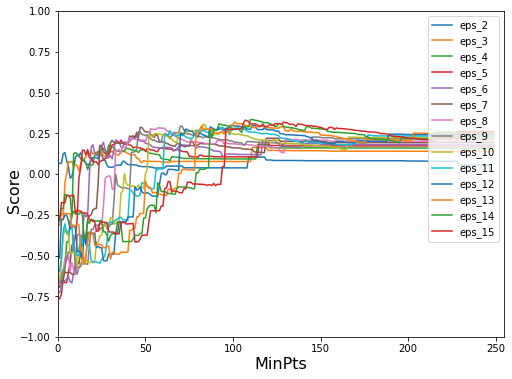

In [569]:
df_scoresAll=pd.DataFrame(scores_all)
df_scoresAll.to_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/Nov/dbscan_scoresall.csv")
# print (df_scoresAll.max(axis=0))
print ("----------------------------------------------------------------------------------------------------------------")
print ("the best hyperparameters are : eps:14; minPts=111 with the best score of 0.335")

plt.figure(figsize=(8,6))
for ep in eps:
    plt.plot(minPts,df_scoresAll[ep],label="eps_{}".format(ep))

ax=plt.gca()
ax.set_xlim(0,255);
ax.set_ylim(-1,1);
ax.set_xlabel("MinPts",fontsize=16)
ax.set_ylabel("Score",fontsize=16)
ax.xaxis.set_label_coords(0.5, -0.06)
ax.yaxis.set_label_coords(-0.08,0.45)
ax.legend(loc="upper right")
plt.show()

# c) clusters and waypoints visualization. 

----------------------------------------------------------------------------------------
Remove all the points close to the terminals



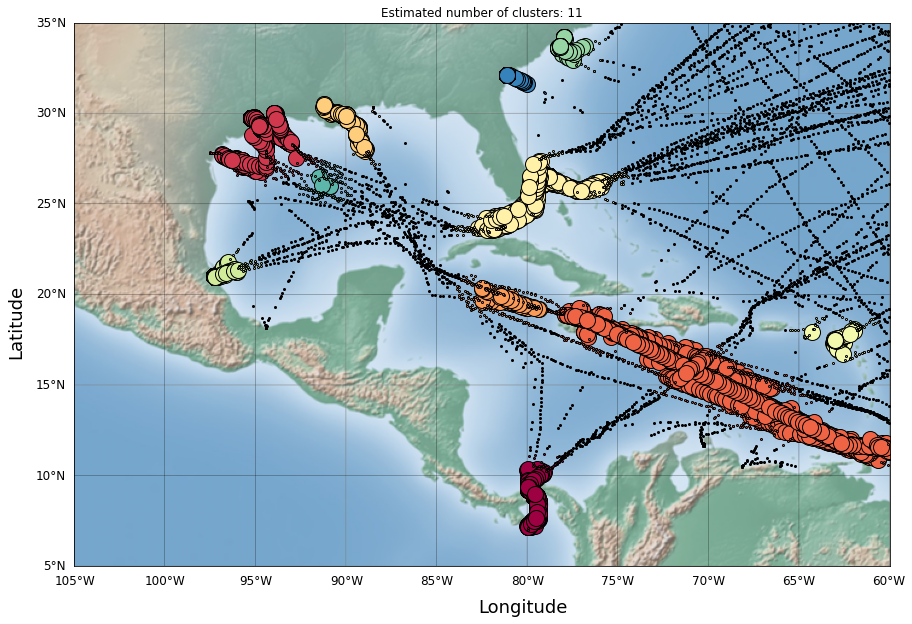

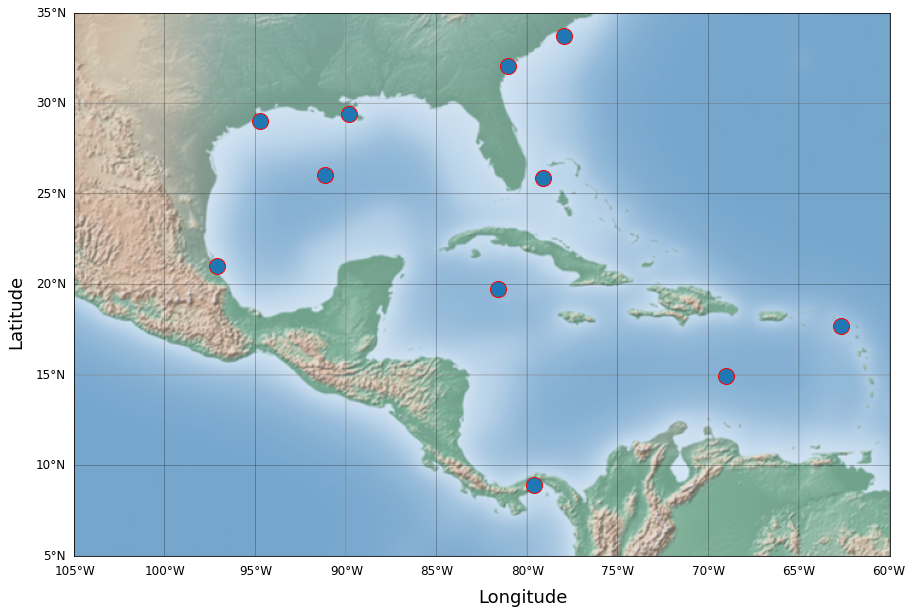

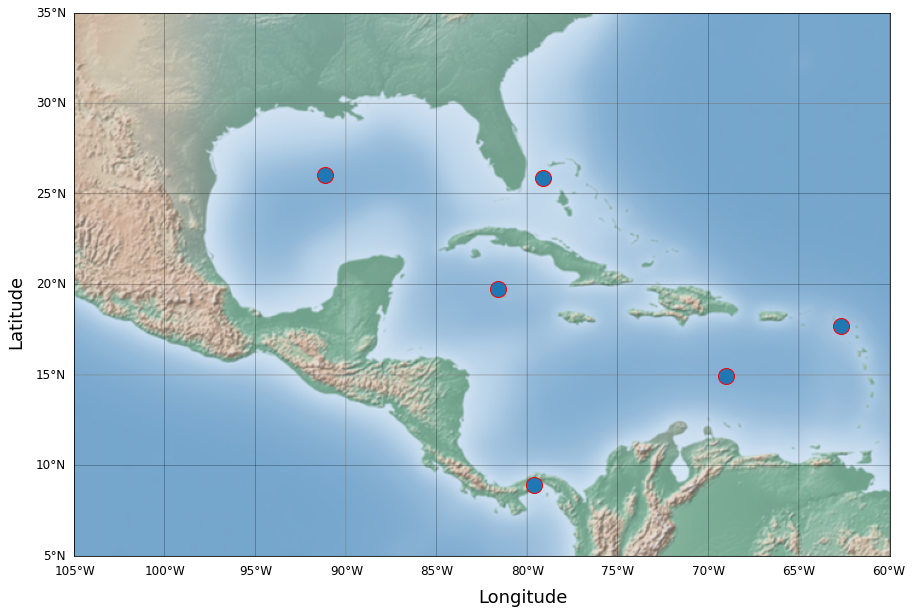

In [625]:
plot_clusters_points(df_gulf_update,dbsc,dispBounds=(5,35,255,300))
# plot_clusters_center(df_clusters,dispBounds=(5,35,255,300))

print ("----------------------------------------------------------------------------------------")
# here, we will remove the points close to the terminals. 
print ("Remove all the points close to the terminals\n")
df_clusters_u=df_clusters[(df_clusters.ais_lon_new>267)&(df_clusters.Latitude<27)]

plot_clusters_center(df_clusters,file_name="waypoints_Gulf.png")
plot_clusters_center(df_clusters_u,file_name="waypoints_Gulf_u.png")
# ax.scatter(centroids_pd_u["ais_lon_new"],centroids_pd_u["Latitude"])

In [577]:
#print the way points of Gulf and Caribbean regions
print("The way points of Gulf and Caribbean reigions:")
df_clusters_u.to_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/Nov/waypoints_gulf.csv")
print (df_clusters_u)

The way points of Gulf and Caribbean reigions:
   ais_lon_new   Latitude
0   280.375343   8.953831
2   291.001873  14.935359
3   278.410327  19.729215
5   280.856102  25.874584
6   297.299159  17.699272
9   268.871946  26.061541


In [620]:
minPts=np.arange(1,250)
scores1=[]
score_max1=0
eps=np.arange(2,21)

scores1_all=dict()

for ep in eps:
    print ("---------------------------------------------------------------------------------------------------------------")
    print ("Current eps distance is:",ep)
    for pt in minPts:
        _, _, _, score=dbscan_train(df_Easia,eps=ep,minPts=pt) 
        if score>score_max1:
            score_max1=score
        scores1_all.setdefault(ep,[]).append(score)


---------------------------------------------------------------------------------------------------------------
Current eps distance is: 2
current minPts : 1
Clustered 6,152 points down to 1,749 clusters, for 71.6% compression in 1.03 seconds
Silhouette coefficient: 0.314
current minPts : 2
Clustered 6,152 points down to 601 clusters, for 90.2% compression in 0.98 seconds
Silhouette coefficient: 0.210
current minPts : 3
Clustered 6,152 points down to 261 clusters, for 95.8% compression in 1.04 seconds
Silhouette coefficient: 0.086
current minPts : 4
Clustered 6,152 points down to 149 clusters, for 97.6% compression in 0.95 seconds
Silhouette coefficient: -0.001
current minPts : 5
Clustered 6,152 points down to 80 clusters, for 98.7% compression in 0.95 seconds
Silhouette coefficient: -0.041
current minPts : 6
Clustered 6,152 points down to 45 clusters, for 99.3% compression in 0.95 seconds
Silhouette coefficient: -0.037
current minPts : 7
Clustered 6,152 points down to 32 clusters, for

current minPts : 62
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.01 seconds
Silhouette coefficient: -0.028
current minPts : 63
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 0.99 seconds
Silhouette coefficient: -0.028
current minPts : 64
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 0.97 seconds
Silhouette coefficient: -0.028
current minPts : 65
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.00 seconds
Silhouette coefficient: -0.028
current minPts : 66
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 0.99 seconds
Silhouette coefficient: -0.028
current minPts : 67
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 0.98 seconds
Silhouette coefficient: -0.028
current minPts : 68
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.00 seconds
Silhouette coefficient: -0.028
current minPts : 69
Clustered 6,152 points down to 10 clusters, for 9

current minPts : 124
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.125
current minPts : 125
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.05 seconds
Silhouette coefficient: 0.125
current minPts : 126
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.00 seconds
Silhouette coefficient: 0.125
current minPts : 127
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.02 seconds
Silhouette coefficient: 0.125
current minPts : 128
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 0.99 seconds
Silhouette coefficient: 0.125
current minPts : 129
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.00 seconds
Silhouette coefficient: 0.125
current minPts : 130
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.00 seconds
Silhouette coefficient: 0.125
current minPts : 131
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 187
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.02 seconds
Silhouette coefficient: 0.123
current minPts : 188
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.05 seconds
Silhouette coefficient: 0.123
current minPts : 189
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 0.99 seconds
Silhouette coefficient: 0.123
current minPts : 190
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.00 seconds
Silhouette coefficient: 0.123
current minPts : 191
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.123
current minPts : 192
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.00 seconds
Silhouette coefficient: 0.123
current minPts : 193
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.01 seconds
Silhouette coefficient: 0.123
current minPts : 194
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 1
Clustered 6,152 points down to 974 clusters, for 84.2% compression in 1.04 seconds
Silhouette coefficient: 0.232
current minPts : 2
Clustered 6,152 points down to 452 clusters, for 92.7% compression in 1.04 seconds
Silhouette coefficient: 0.229
current minPts : 3
Clustered 6,152 points down to 217 clusters, for 96.5% compression in 1.02 seconds
Silhouette coefficient: 0.196
current minPts : 4
Clustered 6,152 points down to 151 clusters, for 97.5% compression in 1.03 seconds
Silhouette coefficient: 0.160
current minPts : 5
Clustered 6,152 points down to 116 clusters, for 98.1% compression in 1.04 seconds
Silhouette coefficient: 0.145
current minPts : 6
Clustered 6,152 points down to 83 clusters, for 98.7% compression in 1.04 seconds
Silhouette coefficient: 0.111
current minPts : 7
Clustered 6,152 points down to 69 clusters, for 98.9% compression in 1.04 seconds
Silhouette coefficient: 0.013
current minPts : 8
Clustered 6,152 points down to 45 clusters, for 99.3% compr

current minPts : 64
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 0.99 seconds
Silhouette coefficient: 0.004
current minPts : 65
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.06 seconds
Silhouette coefficient: 0.004
current minPts : 66
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.01 seconds
Silhouette coefficient: 0.001
current minPts : 67
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.00 seconds
Silhouette coefficient: 0.001
current minPts : 68
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.00 seconds
Silhouette coefficient: -0.009
current minPts : 69
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.00 seconds
Silhouette coefficient: -0.009
current minPts : 70
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.01 seconds
Silhouette coefficient: -0.009
current minPts : 71
Clustered 6,152 points down to 9 clusters, for 99.9% com

current minPts : 126
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.02 seconds
Silhouette coefficient: 0.141
current minPts : 127
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.03 seconds
Silhouette coefficient: 0.140
current minPts : 128
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.04 seconds
Silhouette coefficient: 0.140
current minPts : 129
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.06 seconds
Silhouette coefficient: 0.140
current minPts : 130
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.06 seconds
Silhouette coefficient: 0.140
current minPts : 131
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.05 seconds
Silhouette coefficient: 0.140
current minPts : 132
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.04 seconds
Silhouette coefficient: 0.140
current minPts : 133
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 189
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.02 seconds
Silhouette coefficient: 0.140
current minPts : 190
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.01 seconds
Silhouette coefficient: 0.140
current minPts : 191
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.03 seconds
Silhouette coefficient: 0.140
current minPts : 192
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.03 seconds
Silhouette coefficient: 0.139
current minPts : 193
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.03 seconds
Silhouette coefficient: 0.136
current minPts : 194
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.136
current minPts : 195
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.05 seconds
Silhouette coefficient: 0.136
current minPts : 196
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 2
Clustered 6,152 points down to 254 clusters, for 95.9% compression in 1.03 seconds
Silhouette coefficient: 0.099
current minPts : 3
Clustered 6,152 points down to 142 clusters, for 97.7% compression in 1.08 seconds
Silhouette coefficient: 0.095
current minPts : 4
Clustered 6,152 points down to 109 clusters, for 98.2% compression in 1.08 seconds
Silhouette coefficient: 0.100
current minPts : 5
Clustered 6,152 points down to 71 clusters, for 98.8% compression in 1.04 seconds
Silhouette coefficient: 0.087
current minPts : 6
Clustered 6,152 points down to 79 clusters, for 98.7% compression in 1.09 seconds
Silhouette coefficient: 0.113
current minPts : 7
Clustered 6,152 points down to 58 clusters, for 99.1% compression in 1.06 seconds
Silhouette coefficient: 0.131
current minPts : 8
Clustered 6,152 points down to 48 clusters, for 99.2% compression in 1.07 seconds
Silhouette coefficient: 0.121
current minPts : 9
Clustered 6,152 points down to 48 clusters, for 99.2% compres

current minPts : 65
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.02 seconds
Silhouette coefficient: 0.026
current minPts : 66
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.03 seconds
Silhouette coefficient: 0.026
current minPts : 67
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.02 seconds
Silhouette coefficient: 0.026
current minPts : 68
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.02 seconds
Silhouette coefficient: 0.025
current minPts : 69
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.02 seconds
Silhouette coefficient: 0.025
current minPts : 70
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.02 seconds
Silhouette coefficient: 0.025
current minPts : 71
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.17 seconds
Silhouette coefficient: 0.024
current minPts : 72
Clustered 6,152 points down to 10 clusters, for 99.8% co

current minPts : 127
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.05 seconds
Silhouette coefficient: -0.059
current minPts : 128
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: -0.060
current minPts : 129
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: -0.060
current minPts : 130
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.03 seconds
Silhouette coefficient: -0.060
current minPts : 131
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.05 seconds
Silhouette coefficient: -0.061
current minPts : 132
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.04 seconds
Silhouette coefficient: -0.061
current minPts : 133
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: -0.061
current minPts : 134
Clustered 6,152 points down to 5 clusters, for 9

current minPts : 190
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.04 seconds
Silhouette coefficient: 0.172
current minPts : 191
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.05 seconds
Silhouette coefficient: 0.172
current minPts : 192
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.06 seconds
Silhouette coefficient: 0.172
current minPts : 193
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.172
current minPts : 194
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.04 seconds
Silhouette coefficient: 0.172
current minPts : 195
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.05 seconds
Silhouette coefficient: 0.172
current minPts : 196
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.01 seconds
Silhouette coefficient: 0.172
current minPts : 197
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 3
Clustered 6,152 points down to 92 clusters, for 98.5% compression in 1.09 seconds
Silhouette coefficient: -0.097
current minPts : 4
Clustered 6,152 points down to 77 clusters, for 98.7% compression in 1.09 seconds
Silhouette coefficient: -0.091
current minPts : 5
Clustered 6,152 points down to 63 clusters, for 99.0% compression in 1.14 seconds
Silhouette coefficient: -0.048
current minPts : 6
Clustered 6,152 points down to 60 clusters, for 99.0% compression in 1.07 seconds
Silhouette coefficient: 0.114
current minPts : 7
Clustered 6,152 points down to 51 clusters, for 99.2% compression in 1.06 seconds
Silhouette coefficient: 0.129
current minPts : 8
Clustered 6,152 points down to 42 clusters, for 99.3% compression in 1.05 seconds
Silhouette coefficient: 0.092
current minPts : 9
Clustered 6,152 points down to 41 clusters, for 99.3% compression in 1.05 seconds
Silhouette coefficient: 0.139
current minPts : 10
Clustered 6,152 points down to 30 clusters, for 99.5% compre

current minPts : 66
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.046
current minPts : 67
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.046
current minPts : 68
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.046
current minPts : 69
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.045
current minPts : 70
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.045
current minPts : 71
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.045
current minPts : 72
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.06 seconds
Silhouette coefficient: 0.045
current minPts : 73
Clustered 6,152 points down to 9 clusters, for 99.9% compressio

current minPts : 129
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: -0.021
current minPts : 130
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: -0.024
current minPts : 131
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: -0.048
current minPts : 132
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: -0.048
current minPts : 133
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: -0.048
current minPts : 134
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: -0.048
current minPts : 135
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: -0.049
current minPts : 136
Clustered 6,152 points down to 6 clusters, for 9

current minPts : 191
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.06 seconds
Silhouette coefficient: 0.179
current minPts : 192
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.179
current minPts : 193
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.179
current minPts : 194
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.179
current minPts : 195
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.06 seconds
Silhouette coefficient: 0.179
current minPts : 196
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.179
current minPts : 197
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.06 seconds
Silhouette coefficient: 0.179
current minPts : 198
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 4
Clustered 6,152 points down to 60 clusters, for 99.0% compression in 1.08 seconds
Silhouette coefficient: -0.060
current minPts : 5
Clustered 6,152 points down to 55 clusters, for 99.1% compression in 1.13 seconds
Silhouette coefficient: -0.044
current minPts : 6
Clustered 6,152 points down to 40 clusters, for 99.3% compression in 1.19 seconds
Silhouette coefficient: -0.061
current minPts : 7
Clustered 6,152 points down to 40 clusters, for 99.3% compression in 1.08 seconds
Silhouette coefficient: 0.111
current minPts : 8
Clustered 6,152 points down to 44 clusters, for 99.3% compression in 1.08 seconds
Silhouette coefficient: 0.152
current minPts : 9
Clustered 6,152 points down to 37 clusters, for 99.4% compression in 1.07 seconds
Silhouette coefficient: 0.169
current minPts : 10
Clustered 6,152 points down to 31 clusters, for 99.5% compression in 1.08 seconds
Silhouette coefficient: 0.145
current minPts : 11
Clustered 6,152 points down to 29 clusters, for 99.5% compr

current minPts : 67
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.12 seconds
Silhouette coefficient: 0.054
current minPts : 68
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.09 seconds
Silhouette coefficient: 0.054
current minPts : 69
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.08 seconds
Silhouette coefficient: 0.053
current minPts : 70
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.055
current minPts : 71
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.055
current minPts : 72
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.055
current minPts : 73
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.055
current minPts : 74
Clustered 6,152 points down to 9 clusters, for 99.9% compres

current minPts : 130
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: -0.008
current minPts : 131
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: -0.008
current minPts : 132
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: -0.008
current minPts : 133
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: -0.009
current minPts : 134
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: -0.009
current minPts : 135
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.08 seconds
Silhouette coefficient: -0.009
current minPts : 136
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: -0.009
current minPts : 137
Clustered 6,152 points down to 7 clusters, for 9

current minPts : 192
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.183
current minPts : 193
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.183
current minPts : 194
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.183
current minPts : 195
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.183
current minPts : 196
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.183
current minPts : 197
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.183
current minPts : 198
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.06 seconds
Silhouette coefficient: 0.183
current minPts : 199
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 5
Clustered 6,152 points down to 37 clusters, for 99.4% compression in 1.21 seconds
Silhouette coefficient: -0.098
current minPts : 6
Clustered 6,152 points down to 42 clusters, for 99.3% compression in 1.36 seconds
Silhouette coefficient: 0.017
current minPts : 7
Clustered 6,152 points down to 37 clusters, for 99.4% compression in 1.19 seconds
Silhouette coefficient: 0.031
current minPts : 8
Clustered 6,152 points down to 30 clusters, for 99.5% compression in 1.18 seconds
Silhouette coefficient: 0.008
current minPts : 9
Clustered 6,152 points down to 28 clusters, for 99.5% compression in 1.21 seconds
Silhouette coefficient: -0.041
current minPts : 10
Clustered 6,152 points down to 27 clusters, for 99.6% compression in 1.45 seconds
Silhouette coefficient: 0.167
current minPts : 11
Clustered 6,152 points down to 25 clusters, for 99.6% compression in 1.19 seconds
Silhouette coefficient: 0.204
current minPts : 12
Clustered 6,152 points down to 27 clusters, for 99.6% compr

current minPts : 68
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.12 seconds
Silhouette coefficient: 0.076
current minPts : 69
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.09 seconds
Silhouette coefficient: 0.076
current minPts : 70
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.09 seconds
Silhouette coefficient: 0.075
current minPts : 71
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.09 seconds
Silhouette coefficient: 0.066
current minPts : 72
Clustered 6,152 points down to 12 clusters, for 99.8% compression in 1.18 seconds
Silhouette coefficient: 0.049
current minPts : 73
Clustered 6,152 points down to 12 clusters, for 99.8% compression in 1.63 seconds
Silhouette coefficient: 0.043
current minPts : 74
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.14 seconds
Silhouette coefficient: 0.029
current minPts : 75
Clustered 6,152 points down to 10 clusters, for 99.8% co

current minPts : 131
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.07 seconds
Silhouette coefficient: 0.014
current minPts : 132
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.08 seconds
Silhouette coefficient: 0.014
current minPts : 133
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.08 seconds
Silhouette coefficient: 0.014
current minPts : 134
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.013
current minPts : 135
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.013
current minPts : 136
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.013
current minPts : 137
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.013
current minPts : 138
Clustered 6,152 points down to 7 clusters, for 99.9% co

current minPts : 193
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.206
current minPts : 194
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.08 seconds
Silhouette coefficient: 0.206
current minPts : 195
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.206
current minPts : 196
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.08 seconds
Silhouette coefficient: 0.206
current minPts : 197
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.206
current minPts : 198
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.206
current minPts : 199
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.206
current minPts : 200
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 6
Clustered 6,152 points down to 34 clusters, for 99.4% compression in 1.09 seconds
Silhouette coefficient: -0.061
current minPts : 7
Clustered 6,152 points down to 24 clusters, for 99.6% compression in 1.08 seconds
Silhouette coefficient: -0.041
current minPts : 8
Clustered 6,152 points down to 28 clusters, for 99.5% compression in 1.08 seconds
Silhouette coefficient: 0.118
current minPts : 9
Clustered 6,152 points down to 27 clusters, for 99.6% compression in 1.07 seconds
Silhouette coefficient: 0.105
current minPts : 10
Clustered 6,152 points down to 22 clusters, for 99.6% compression in 1.08 seconds
Silhouette coefficient: -0.124
current minPts : 11
Clustered 6,152 points down to 21 clusters, for 99.7% compression in 1.08 seconds
Silhouette coefficient: 0.175
current minPts : 12
Clustered 6,152 points down to 21 clusters, for 99.7% compression in 1.11 seconds
Silhouette coefficient: 0.244
current minPts : 13
Clustered 6,152 points down to 17 clusters, for 99.7% com

current minPts : 69
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.121
current minPts : 70
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.18 seconds
Silhouette coefficient: 0.105
current minPts : 71
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.15 seconds
Silhouette coefficient: 0.105
current minPts : 72
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.10 seconds
Silhouette coefficient: 0.105
current minPts : 73
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.19 seconds
Silhouette coefficient: 0.105
current minPts : 74
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.15 seconds
Silhouette coefficient: 0.103
current minPts : 75
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.12 seconds
Silhouette coefficient: 0.102
current minPts : 76
Clustered 6,152 points down to 10 clusters, for 99.8% com

current minPts : 132
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.065
current minPts : 133
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.064
current minPts : 134
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.064
current minPts : 135
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.027
current minPts : 136
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.027
current minPts : 137
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.027
current minPts : 138
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.027
current minPts : 139
Clustered 6,152 points down to 6 clusters, for 99.9% co

current minPts : 194
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.216
current minPts : 195
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.216
current minPts : 196
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.216
current minPts : 197
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.216
current minPts : 198
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.216
current minPts : 199
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.216
current minPts : 200
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.216
current minPts : 201
Clustered 6,152 points down to 4 clusters, for 99.9% co

current minPts : 7
Clustered 6,152 points down to 23 clusters, for 99.6% compression in 1.16 seconds
Silhouette coefficient: -0.055
current minPts : 8
Clustered 6,152 points down to 20 clusters, for 99.7% compression in 1.12 seconds
Silhouette coefficient: 0.132
current minPts : 9
Clustered 6,152 points down to 19 clusters, for 99.7% compression in 1.22 seconds
Silhouette coefficient: 0.131
current minPts : 10
Clustered 6,152 points down to 22 clusters, for 99.6% compression in 1.23 seconds
Silhouette coefficient: 0.213
current minPts : 11
Clustered 6,152 points down to 18 clusters, for 99.7% compression in 1.15 seconds
Silhouette coefficient: 0.190
current minPts : 12
Clustered 6,152 points down to 16 clusters, for 99.7% compression in 1.12 seconds
Silhouette coefficient: 0.024
current minPts : 13
Clustered 6,152 points down to 18 clusters, for 99.7% compression in 1.08 seconds
Silhouette coefficient: 0.270
current minPts : 14
Clustered 6,152 points down to 15 clusters, for 99.8% comp

current minPts : 70
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.130
current minPts : 71
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.129
current minPts : 72
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.129
current minPts : 73
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.127
current minPts : 74
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.127
current minPts : 75
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.127
current minPts : 76
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.127
current minPts : 77
Clustered 6,152 points down to 9 clusters, for 99.9% compressio

current minPts : 133
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.071
current minPts : 134
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.08 seconds
Silhouette coefficient: 0.071
current minPts : 135
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.08 seconds
Silhouette coefficient: 0.071
current minPts : 136
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.034
current minPts : 137
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.09 seconds
Silhouette coefficient: 0.034
current minPts : 138
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.032
current minPts : 139
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.032
current minPts : 140
Clustered 6,152 points down to 6 clusters, for 99.9% co

current minPts : 196
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.221
current minPts : 197
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.10 seconds
Silhouette coefficient: 0.221
current minPts : 198
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.221
current minPts : 199
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.11 seconds
Silhouette coefficient: 0.221
current minPts : 200
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.221
current minPts : 201
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.221
current minPts : 202
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.221
current minPts : 203
Clustered 6,152 points down to 4 clusters, for 99.9% co

current minPts : 9
Clustered 6,152 points down to 20 clusters, for 99.7% compression in 1.15 seconds
Silhouette coefficient: 0.033
current minPts : 10
Clustered 6,152 points down to 18 clusters, for 99.7% compression in 1.14 seconds
Silhouette coefficient: 0.131
current minPts : 11
Clustered 6,152 points down to 14 clusters, for 99.8% compression in 1.12 seconds
Silhouette coefficient: 0.152
current minPts : 12
Clustered 6,152 points down to 15 clusters, for 99.8% compression in 1.12 seconds
Silhouette coefficient: 0.146
current minPts : 13
Clustered 6,152 points down to 15 clusters, for 99.8% compression in 1.16 seconds
Silhouette coefficient: 0.092
current minPts : 14
Clustered 6,152 points down to 13 clusters, for 99.8% compression in 1.18 seconds
Silhouette coefficient: 0.124
current minPts : 15
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.13 seconds
Silhouette coefficient: 0.178
current minPts : 16
Clustered 6,152 points down to 11 clusters, for 99.8% com

current minPts : 72
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.143
current minPts : 73
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.140
current minPts : 74
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.138
current minPts : 75
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.138
current minPts : 76
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.138
current minPts : 77
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.138
current minPts : 78
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.138
current minPts : 79
Clustered 6,152 points down to 9 clusters, for 99.9% compressio

current minPts : 135
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.086
current minPts : 136
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.086
current minPts : 137
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.086
current minPts : 138
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.086
current minPts : 139
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.086
current minPts : 140
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.048
current minPts : 141
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.048
current minPts : 142
Clustered 6,152 points down to 6 clusters, for 99.9% co

current minPts : 198
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.223
current minPts : 199
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.223
current minPts : 200
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.223
current minPts : 201
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.223
current minPts : 202
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.223
current minPts : 203
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.12 seconds
Silhouette coefficient: 0.223
current minPts : 204
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.13 seconds
Silhouette coefficient: 0.223
current minPts : 205
Clustered 6,152 points down to 4 clusters, for 99.9% co

current minPts : 11
Clustered 6,152 points down to 13 clusters, for 99.8% compression in 1.29 seconds
Silhouette coefficient: 0.154
current minPts : 12
Clustered 6,152 points down to 12 clusters, for 99.8% compression in 1.24 seconds
Silhouette coefficient: 0.158
current minPts : 13
Clustered 6,152 points down to 13 clusters, for 99.8% compression in 1.31 seconds
Silhouette coefficient: 0.149
current minPts : 14
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.27 seconds
Silhouette coefficient: 0.273
current minPts : 15
Clustered 6,152 points down to 14 clusters, for 99.8% compression in 1.25 seconds
Silhouette coefficient: 0.133
current minPts : 16
Clustered 6,152 points down to 13 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.125
current minPts : 17
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.25 seconds
Silhouette coefficient: 0.185
current minPts : 18
Clustered 6,152 points down to 10 clusters, for 99.8% co

current minPts : 74
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.133
current minPts : 75
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.130
current minPts : 76
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.128
current minPts : 77
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.126
current minPts : 78
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.25 seconds
Silhouette coefficient: 0.124
current minPts : 79
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.146
current minPts : 80
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.14 seconds
Silhouette coefficient: 0.146
current minPts : 81
Clustered 6,152 points down to 8 clusters, for 99.9% compressio

current minPts : 137
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.100
current minPts : 138
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.100
current minPts : 139
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.100
current minPts : 140
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.100
current minPts : 141
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.100
current minPts : 142
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.079
current minPts : 143
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.079
current minPts : 144
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 200
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.25 seconds
Silhouette coefficient: 0.021
current minPts : 201
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.021
current minPts : 202
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.021
current minPts : 203
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.020
current minPts : 204
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.020
current minPts : 205
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.020
current minPts : 206
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.020
current minPts : 207
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 13
Clustered 6,152 points down to 12 clusters, for 99.8% compression in 1.18 seconds
Silhouette coefficient: 0.144
current minPts : 14
Clustered 6,152 points down to 12 clusters, for 99.8% compression in 1.17 seconds
Silhouette coefficient: 0.152
current minPts : 15
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.23 seconds
Silhouette coefficient: 0.163
current minPts : 16
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.158
current minPts : 17
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.21 seconds
Silhouette coefficient: 0.141
current minPts : 18
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.26 seconds
Silhouette coefficient: 0.253
current minPts : 19
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.216
current minPts : 20
Clustered 6,152 points down to 9 clusters, for 99.9% comp

current minPts : 76
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.148
current minPts : 77
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.147
current minPts : 78
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.147
current minPts : 79
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.146
current minPts : 80
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.145
current minPts : 81
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.144
current minPts : 82
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.137
current minPts : 83
Clustered 6,152 points down to 9 clusters, for 99.9% compressio

current minPts : 139
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.105
current minPts : 140
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.105
current minPts : 141
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.105
current minPts : 142
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.105
current minPts : 143
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.105
current minPts : 144
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.105
current minPts : 145
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.105
current minPts : 146
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 202
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.033
current minPts : 203
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.033
current minPts : 204
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.32 seconds
Silhouette coefficient: 0.033
current minPts : 205
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.35 seconds
Silhouette coefficient: 0.033
current minPts : 206
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.43 seconds
Silhouette coefficient: 0.033
current minPts : 207
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.33 seconds
Silhouette coefficient: 0.033
current minPts : 208
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.33 seconds
Silhouette coefficient: 0.033
current minPts : 209
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 15
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.309
current minPts : 16
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.308
current minPts : 17
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.19 seconds
Silhouette coefficient: 0.163
current minPts : 18
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.273
current minPts : 19
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.19 seconds
Silhouette coefficient: 0.270
current minPts : 20
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.358
current minPts : 21
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.17 seconds
Silhouette coefficient: 0.204
current minPts : 22
Clustered 6,152 points down to 9 clusters, for 99.9% compre

current minPts : 78
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.214
current minPts : 79
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.209
current minPts : 80
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.206
current minPts : 81
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.205
current minPts : 82
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.205
current minPts : 83
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.204
current minPts : 84
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.199
current minPts : 85
Clustered 6,152 points down to 8 clusters, for 99.9% compressio

current minPts : 141
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.112
current minPts : 142
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.111
current minPts : 143
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.111
current minPts : 144
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.30 seconds
Silhouette coefficient: 0.111
current minPts : 145
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.111
current minPts : 146
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.111
current minPts : 147
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.111
current minPts : 148
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 204
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.040
current minPts : 205
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.040
current minPts : 206
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.040
current minPts : 207
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.040
current minPts : 208
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.040
current minPts : 209
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.038
current minPts : 210
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.25 seconds
Silhouette coefficient: 0.037
current minPts : 211
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 17
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.24 seconds
Silhouette coefficient: 0.165
current minPts : 18
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.165
current minPts : 19
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.19 seconds
Silhouette coefficient: 0.164
current minPts : 20
Clustered 6,152 points down to 11 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.273
current minPts : 21
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.347
current minPts : 22
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.346
current minPts : 23
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.200
current minPts : 24
Clustered 6,152 points down to 9 clusters, for 99.9% compres

current minPts : 80
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.22 seconds
Silhouette coefficient: 0.217
current minPts : 81
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.213
current minPts : 82
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.213
current minPts : 83
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.207
current minPts : 84
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.201
current minPts : 85
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.225
current minPts : 86
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.224
current minPts : 87
Clustered 6,152 points down to 8 clusters, for 99.9% compressi

current minPts : 143
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.121
current minPts : 144
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.121
current minPts : 145
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.121
current minPts : 146
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.121
current minPts : 147
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.121
current minPts : 148
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.121
current minPts : 149
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.121
current minPts : 150
Clustered 6,152 points down to 6 clusters, for 99.9% co

current minPts : 206
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.053
current minPts : 207
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.053
current minPts : 208
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.053
current minPts : 209
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.32 seconds
Silhouette coefficient: 0.053
current minPts : 210
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.053
current minPts : 211
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.29 seconds
Silhouette coefficient: 0.052
current minPts : 212
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.052
current minPts : 213
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 19
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.314
current minPts : 20
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.312
current minPts : 21
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.23 seconds
Silhouette coefficient: 0.165
current minPts : 22
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.328
current minPts : 23
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.363
current minPts : 24
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.28 seconds
Silhouette coefficient: 0.217
current minPts : 25
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.205
current minPts : 26
Clustered 6,152 points down to 9 clusters, for 99.9% compressi

current minPts : 82
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.15 seconds
Silhouette coefficient: 0.269
current minPts : 83
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.16 seconds
Silhouette coefficient: 0.244
current minPts : 84
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.239
current minPts : 85
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.238
current minPts : 86
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.238
current minPts : 87
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.238
current minPts : 88
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.15 seconds
Silhouette coefficient: 0.235
current minPts : 89
Clustered 6,152 points down to 9 clusters, for 99.9% compress

current minPts : 145
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.132
current minPts : 146
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.132
current minPts : 147
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.132
current minPts : 148
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.132
current minPts : 149
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.132
current minPts : 150
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.132
current minPts : 151
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.132
current minPts : 152
Clustered 6,152 points down to 6 clusters, for 99.9% co

current minPts : 208
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.085
current minPts : 209
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.081
current minPts : 210
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.081
current minPts : 211
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.081
current minPts : 212
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.081
current minPts : 213
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.081
current minPts : 214
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.25 seconds
Silhouette coefficient: 0.081
current minPts : 215
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 21
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.151
current minPts : 22
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.313
current minPts : 23
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.149
current minPts : 24
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.330
current minPts : 25
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.328
current minPts : 26
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.328
current minPts : 27
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.387
current minPts : 28
Clustered 6,152 points down to 7 clusters, for 99.9% compressio

current minPts : 84
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.17 seconds
Silhouette coefficient: 0.307
current minPts : 85
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.295
current minPts : 86
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.291
current minPts : 87
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.17 seconds
Silhouette coefficient: 0.289
current minPts : 88
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.19 seconds
Silhouette coefficient: 0.284
current minPts : 89
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.21 seconds
Silhouette coefficient: 0.283
current minPts : 90
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.301
current minPts : 91
Clustered 6,152 points down to 9 clusters, for 99.9% comp

current minPts : 147
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.154
current minPts : 148
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.152
current minPts : 149
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.152
current minPts : 150
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.146
current minPts : 151
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.146
current minPts : 152
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.143
current minPts : 153
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.139
current minPts : 154
Clustered 6,152 points down to 6 clusters, for 99.9% co

current minPts : 210
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.104
current minPts : 211
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.094
current minPts : 212
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.094
current minPts : 213
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.093
current minPts : 214
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.28 seconds
Silhouette coefficient: 0.093
current minPts : 215
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.32 seconds
Silhouette coefficient: 0.092
current minPts : 216
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.092
current minPts : 217
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 23
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.155
current minPts : 24
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.314
current minPts : 25
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.317
current minPts : 26
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.333
current minPts : 27
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.332
current minPts : 28
Clustered 6,152 points down to 6 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.358
current minPts : 29
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.388
current minPts : 30
Clustered 6,152 points down to 8 clusters, for 99.9% compressio

current minPts : 86
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.17 seconds
Silhouette coefficient: 0.337
current minPts : 87
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.336
current minPts : 88
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.17 seconds
Silhouette coefficient: 0.335
current minPts : 89
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.18 seconds
Silhouette coefficient: 0.327
current minPts : 90
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.27 seconds
Silhouette coefficient: 0.323
current minPts : 91
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.16 seconds
Silhouette coefficient: 0.320
current minPts : 92
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.18 seconds
Silhouette coefficient: 0.320
current minPts : 93
Clustered 6,152 points down to 10 clusters, for 99.8% co

current minPts : 149
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.180
current minPts : 150
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.179
current minPts : 151
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.171
current minPts : 152
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.16 seconds
Silhouette coefficient: 0.167
current minPts : 153
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.17 seconds
Silhouette coefficient: 0.165
current minPts : 154
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.165
current minPts : 155
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.165
current minPts : 156
Clustered 6,152 points down to 7 clusters, for 99.9% co

current minPts : 212
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.119
current minPts : 213
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.119
current minPts : 214
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.116
current minPts : 215
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.116
current minPts : 216
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.116
current minPts : 217
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.116
current minPts : 218
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.116
current minPts : 219
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 25
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.155
current minPts : 26
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.317
current minPts : 27
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.334
current minPts : 28
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.340
current minPts : 29
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.340
current minPts : 30
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.167
current minPts : 31
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.364
current minPts : 32
Clustered 6,152 points down to 6 clusters, for 99.9% compressio

current minPts : 88
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.34 seconds
Silhouette coefficient: 0.363
current minPts : 89
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.22 seconds
Silhouette coefficient: 0.361
current minPts : 90
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.357
current minPts : 91
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.21 seconds
Silhouette coefficient: 0.353
current minPts : 92
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.17 seconds
Silhouette coefficient: 0.349
current minPts : 93
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.347
current minPts : 94
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.23 seconds
Silhouette coefficient: 0.344
current minPts : 95
Clustered 6,152 points down to 10 clusters, for 99.8% co

current minPts : 151
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.207
current minPts : 152
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.206
current minPts : 153
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.205
current minPts : 154
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.19 seconds
Silhouette coefficient: 0.202
current minPts : 155
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.18 seconds
Silhouette coefficient: 0.196
current minPts : 156
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.189
current minPts : 157
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.189
current minPts : 158
Clustered 6,152 points down to 7 clusters, for 99.9% co

current minPts : 214
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.130
current minPts : 215
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.130
current minPts : 216
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.130
current minPts : 217
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.30 seconds
Silhouette coefficient: 0.129
current minPts : 218
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.129
current minPts : 219
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.129
current minPts : 220
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.29 seconds
Silhouette coefficient: 0.129
current minPts : 221
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 27
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.158
current minPts : 28
Clustered 6,152 points down to 9 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.158
current minPts : 29
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.319
current minPts : 30
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.324
current minPts : 31
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.355
current minPts : 32
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.369
current minPts : 33
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.368
current minPts : 34
Clustered 6,152 points down to 6 clusters, for 99.9% compressio

current minPts : 90
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.32 seconds
Silhouette coefficient: 0.392
current minPts : 91
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.46 seconds
Silhouette coefficient: 0.392
current minPts : 92
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.55 seconds
Silhouette coefficient: 0.385
current minPts : 93
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.35 seconds
Silhouette coefficient: 0.381
current minPts : 94
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.36 seconds
Silhouette coefficient: 0.377
current minPts : 95
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.24 seconds
Silhouette coefficient: 0.376
current minPts : 96
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.20 seconds
Silhouette coefficient: 0.375
current minPts : 97
Clustered 6,152 points down to 10 clusters, for 99.8% co

current minPts : 152
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.236
current minPts : 153
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.225
current minPts : 154
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.218
current minPts : 155
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.33 seconds
Silhouette coefficient: 0.218
current minPts : 156
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.218
current minPts : 157
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.25 seconds
Silhouette coefficient: 0.217
current minPts : 158
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.216
current minPts : 159
Clustered 6,152 points down to 7 clusters, for 99.9% co

current minPts : 215
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.138
current minPts : 216
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.137
current minPts : 217
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.137
current minPts : 218
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.32 seconds
Silhouette coefficient: 0.137
current minPts : 219
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.20 seconds
Silhouette coefficient: 0.137
current minPts : 220
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.136
current minPts : 221
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.28 seconds
Silhouette coefficient: 0.135
current minPts : 222
Clustered 6,152 points down to 5 clusters, for 99.9% co

current minPts : 28
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.322
current minPts : 29
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.27 seconds
Silhouette coefficient: 0.323
current minPts : 30
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.28 seconds
Silhouette coefficient: 0.160
current minPts : 31
Clustered 6,152 points down to 8 clusters, for 99.9% compression in 1.41 seconds
Silhouette coefficient: 0.320
current minPts : 32
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.32 seconds
Silhouette coefficient: 0.344
current minPts : 33
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.36 seconds
Silhouette coefficient: 0.380
current minPts : 34
Clustered 6,152 points down to 4 clusters, for 99.9% compression in 1.36 seconds
Silhouette coefficient: 0.379
current minPts : 35
Clustered 6,152 points down to 5 clusters, for 99.9% compressio

current minPts : 91
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.24 seconds
Silhouette coefficient: 0.415
current minPts : 92
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.22 seconds
Silhouette coefficient: 0.413
current minPts : 93
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.25 seconds
Silhouette coefficient: 0.411
current minPts : 94
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.31 seconds
Silhouette coefficient: 0.410
current minPts : 95
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.23 seconds
Silhouette coefficient: 0.409
current minPts : 96
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.23 seconds
Silhouette coefficient: 0.407
current minPts : 97
Clustered 6,152 points down to 10 clusters, for 99.8% compression in 1.23 seconds
Silhouette coefficient: 0.405
current minPts : 98
Clustered 6,152 points down to 10 clusters, for 99.8% co

current minPts : 153
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.272
current minPts : 154
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.270
current minPts : 155
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.25 seconds
Silhouette coefficient: 0.266
current minPts : 156
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.23 seconds
Silhouette coefficient: 0.266
current minPts : 157
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.31 seconds
Silhouette coefficient: 0.265
current minPts : 158
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.264
current minPts : 159
Clustered 6,152 points down to 7 clusters, for 99.9% compression in 1.22 seconds
Silhouette coefficient: 0.264
current minPts : 160
Clustered 6,152 points down to 7 clusters, for 99.9% co

current minPts : 216
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.25 seconds
Silhouette coefficient: 0.147
current minPts : 217
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.21 seconds
Silhouette coefficient: 0.147
current minPts : 218
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.24 seconds
Silhouette coefficient: 0.146
current minPts : 219
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.26 seconds
Silhouette coefficient: 0.146
current minPts : 220
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.41 seconds
Silhouette coefficient: 0.145
current minPts : 221
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.50 seconds
Silhouette coefficient: 0.145
current minPts : 222
Clustered 6,152 points down to 5 clusters, for 99.9% compression in 1.46 seconds
Silhouette coefficient: 0.145
current minPts : 223
Clustered 6,152 points down to 5 clusters, for 99.9% co

NameError: name 'score1_max' is not defined

----------------------------------------------------------------------------------------------------------------
the best hyperparameters are : eps:14; minPts=111 with the best score of 0.335


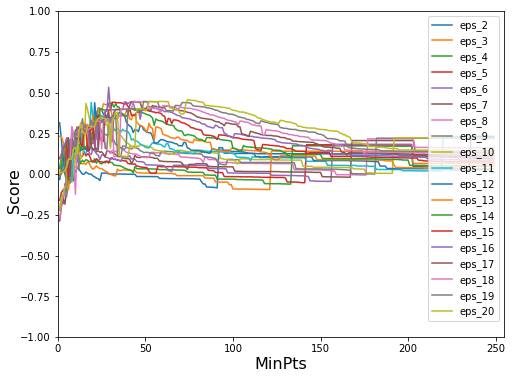

In [626]:
df_scoresAll_1=pd.DataFrame(scores1_all)
df_scoresAll_1.to_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/Nov/dbscan_scoresall_1.csv")
# print (df_scoresAll.max(axis=0))
print ("----------------------------------------------------------------------------------------------------------------")
print ("the best hyperparameters are : eps:14; minPts=111 with the best score of 0.335")

plt.figure(figsize=(8,6))
for ep in eps:
    plt.plot(minPts,df_scoresAll_1[ep],label="eps_{}".format(ep))

ax=plt.gca()
ax.set_xlim(0,255);
ax.set_ylim(-1,1);
ax.set_xlabel("MinPts",fontsize=16)
ax.set_ylabel("Score",fontsize=16)
ax.xaxis.set_label_coords(0.5, -0.06)
ax.yaxis.set_label_coords(-0.08,0.45)
ax.legend(loc="upper right")
plt.show()

----------------------------------------------------------------------------------------
    ais_lon_new   Latitude
2    125.104615  34.779903
4    125.748366  36.310556
10   128.384651  34.792936
7    129.205704  30.755128
14   139.540065  33.513723
8    141.778283  34.816005
3    142.274458  31.176568
9    142.278933  41.445650
13   145.296389  36.032919
11   146.750186  42.626452
5    147.963210  31.491305


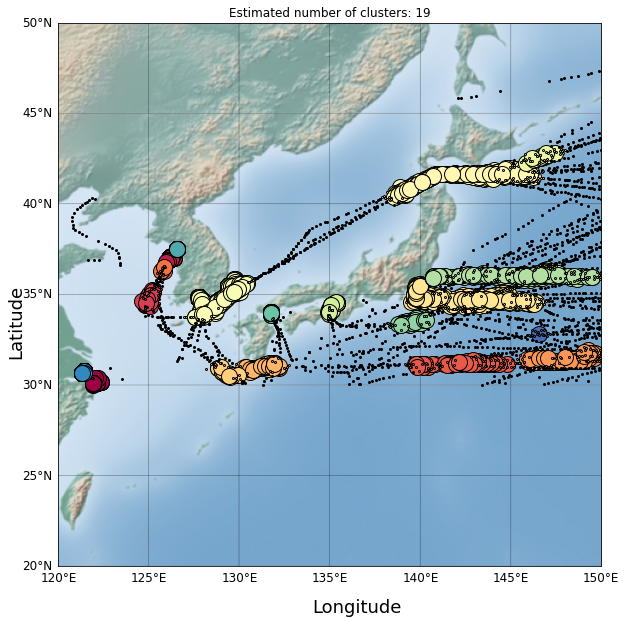

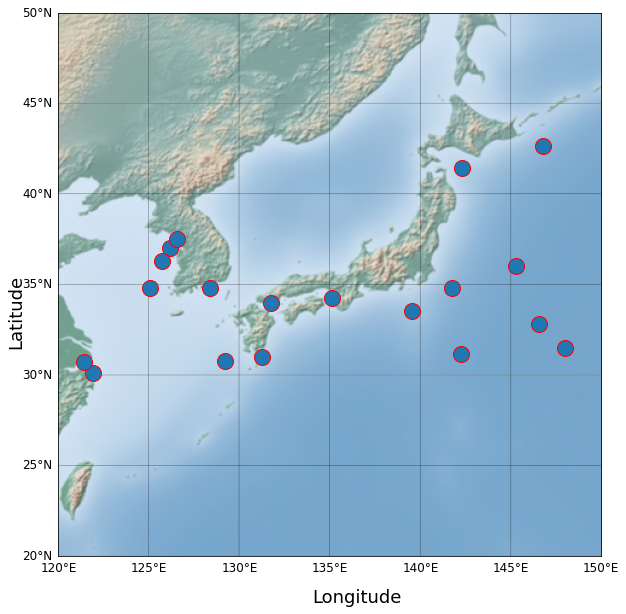

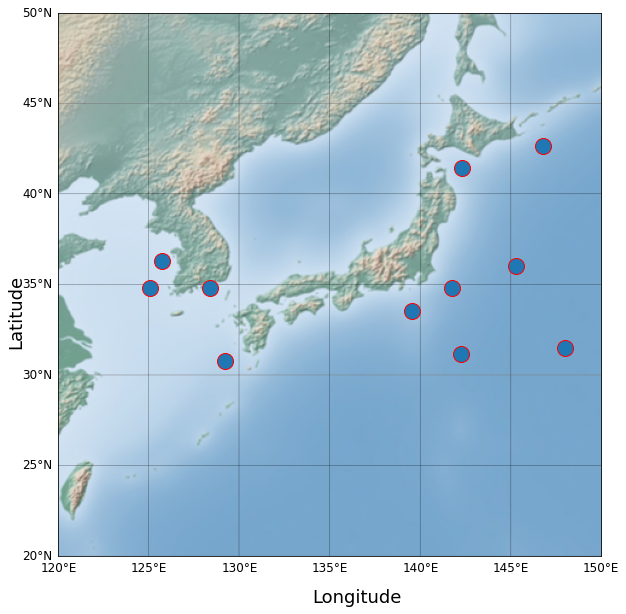

In [685]:
plot_clusters_points(df_Easia,dbsc1,dispBounds=(20,50,120,150),file_name="waypoints_Clusters_Asia.png")
# plot_clusters_center(df_clusters,dispBounds=(5,35,255,300))

print ("----------------------------------------------------------------------------------------")

plot_clusters_center(df_clusters1,(20,50,120,150),file_name="waypoints_Asia.png")
# ax.scatter(centroids_pd_u["ais_lon_new"],centroids_pd_u["Latitude"])

# # here, we will remove the points close to the terminals. 
# print ("Remove all the points close to the terminals\n")
df_clusters1.sort_values(by=["ais_lon_new"])
df_clusters1_u=df_clusters1.loc[[2,4,10,7,14,8,3,9,13,11,5]]
print (df_clusters1_u)
plot_clusters_center(df_clusters1_u,(20,50,120,150),file_name="waypoints_Asia_1.png")
df_clusters1_u.to_csv("C:/posDoc-SDU-Denmark/SDU_research/shippingLabwp1/Nov/waypoints_NE_asia.csv")